# 🚀 MuRIL Tweet Sentiment Analysis - Complete Pipeline

This notebook performs sentiment analysis on Nepali tweets using the MuRIL model.

## Features:
- ✅ Complete data preprocessing
- ✅ Automated labeling with teacher model
- ✅ Training with proper tracking
- ✅ Comprehensive visualization
- ✅ Training & Validation metrics tracking
- ✅ Model saving and evaluation

---

## 📦 Step 1: Installation and Setup

In [ ]:
# Install required libraries
!pip install -q transformers[torch] datasets scikit-learn sentencepiece huggingface_hub emoji

print("✅ Installation complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 16.3 MB/s eta 0:00:00
✅ Installation complete!


In [ ]:
# Authenticate with Hugging Face
# Get your token from: https://huggingface.co/settings/tokens
from huggingface_hub import login

login()
print("✅ Hugging Face authentication complete!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Hugging Face authentication complete!


## 📚 Step 2: Import Libraries and Set Configuration

In [ ]:
# Import all required libraries
import pandas as pd
import re
import emoji
import numpy as np
import torch
import random
import time
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
    TrainerCallback
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

# Configuration
SEED = 42
MODEL_NAME = "google/muril-base-cased"
MAX_LENGTH = 128
BATCH_SIZE = 16
EVAL_BATCH_SIZE = 16
NUM_EPOCHS = 3
LEARNING_RATE = 2e-5
TEST_SIZE = 0.2

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

print("="*60)
print("🔧 CONFIGURATION")
print("="*60)
print(f"Device: {device}")
print(f"Model: {MODEL_NAME}")
print(f"Random Seed: {SEED}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print("="*60)
print("✅ Libraries imported and configuration set!")

🔧 CONFIGURATION
Device: cuda
Model: google/muril-base-cased
Random Seed: 42
Batch Size: 16
Epochs: 3
Learning Rate: 2e-05
✅ Libraries imported and configuration set!


## 📂 Step 3: Load and Clean Data

In [ ]:
# Load your dataset
# Replace 'combined_dataset_final_2.csv' with your actual file path
df = pd.read_csv('combined_dataset_final_2.csv')

print(f"📊 Loaded {len(df)} tweets")
print(f"Columns: {df.columns.tolist()}")
display(df.head())

📊 Loaded 3624 tweets
Columns: ['tweet_id', 'party', 'username', 'name', 'date', 'time', 'full_text', 'like', 'retweet_count', 'reply_count', 'view_count', 'followers_count']


,tweet_id,party,username,name,date,time,full_text,like,retweet_count,reply_count,view_count,followers_count
0,1.73778E+18,CPN (SC),Bhanubhakta99,Bhanubhakta Joshi,12/21/2023,16:19:16,‘६०प्रतिशत विद्यार्थी स्कुल गएका छैनन्’ https:...,1,1,0,168,17
1,1.73778E+18,CPN (SC),Bhanubhakta99,Bhanubhakta Joshi,12/21/2023,16:16:43,RT @EduKhabar: सामुदायिक विद्यालयमा १० वर्ष पढ...,0,4,0,0,17
2,1.5313E+18,CPN (SC),Krishnacpnus,Krishna Kumar Shrestha,5/30/2022,21:35:49,https://t.co/yNDAB7elEU,1,0,1,0,69
3,1.5313E+18,CPN (SC),Krishnacpnus,Krishna Kumar Shrestha,5/30/2022,21:34:18,https://t.co/g97kWpTdnn,0,0,0,0,69
4,1.5313E+18,CPN (SC),Krishnacpnus,Krishna Kumar Shrestha,5/30/2022,21:34:07,https://t.co/C3eLyMYI9J,0,0,0,0,69


In [ ]:
def clean_nepali_text(text):
    """Clean and preprocess Nepali text"""
    if pd.isna(text):
        return ""

    # Convert to string
    text = str(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#', '', text)

    # Remove emojis
    text = emoji.replace_emoji(text, replace='')

    # Keep only Nepali Devanagari (\u0900-\u097F) and English letters
    text = re.sub(r'[^A-Za-z\u0900-\u097F\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply cleaning
print("🧹 Cleaning text...")
df['cleaned_text'] = df['full_text'].apply(clean_nepali_text)

# Remove empty tweets
df = df[df['cleaned_text'] != ""].reset_index(drop=True)

print(f"✅ Cleaning complete! {len(df)} tweets after cleaning")
print("\n📝 Sample cleaned tweets:")
display(df[['full_text', 'cleaned_text']].head(10))

🧹 Cleaning text...
✅ Cleaning complete! 3449 tweets after cleaning

📝 Sample cleaned tweets:


,full_text,cleaned_text
0,‘६०प्रतिशत विद्यार्थी स्कुल गएका छैनन्’ https:...,६०प्रतिशत विद्यार्थी स्कुल गएका छैनन्
1,RT @EduKhabar: सामुदायिक विद्यालयमा १० वर्ष पढ...,RT सामुदायिक विद्यालयमा १० वर्ष पढाएपछि स्वतः ...
2,नेपाली बौद्धमार्गी एवं हिमाली आदिवासी शेर्पा स...,नेपाली बौद्धमार्गी एवं हिमाली आदिवासी शेर्पा स...
3,RT @ourktv: अलपत्र नेपालीको व्यवस्थापनका लागि ...,RT अलपत्र नेपालीको व्यवस्थापनका लागि सीआईबीको ...
4,RT @NAYA_PATRIKA: रोजगारीको प्रलोभन देखाएर अलप...,RT रोजगारीको प्रलोभन देखाएर अलपत्र पार्ने म्या...
5,RT @ThahaKhabar: मेरो सचिवालयको मोबाइल नम्बर ९...,RT मेरो सचिवालयको मोबाइल नम्बर ९८२३३५६७०४ र ९८...
6,RT @Ujyaalo: श्रममन्त्री कृष्णकुमार श्रेष्ठको ...,RT श्रममन्त्री कृष्णकुमार श्रेष्ठको अपील
7,RT @ThahaKhabar: वैदेशिक रोजगारीको नाममा ठगीमा...,RT वैदेशिक रोजगारीको नाममा ठगीमा परे मलाई फोन ...
8,RT @Nepalkhabar24: भिजिट भिसामा विदेश लगेर नेप...,RT भिजिट भिसामा विदेश लगेर नेपालीलाई दलालले अल...
9,RT @cpn_socialist: https://t.co/nHX3bIK2T4,RT


## 🏷️ Step 4: Automated Labeling with Teacher Model

In [ ]:
print("🤖 Initializing teacher model for automated labeling...")
print("This may take a few minutes...\n")

# Initialize zero-shot classification model
teacher = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7",
    device=0 if torch.cuda.is_available() else -1
)

# Define candidate labels
candidate_labels = ["Development", "Political"]

print("✅ Teacher model loaded!")
print(f"Labels: {candidate_labels}")

🤖 Initializing teacher model for automated labeling...
This may take a few minutes...



config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/202 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7
Key                             | Status     |  | 
--------------------------------+------------+--+-
deberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

✅ Teacher model loaded!
Labels: ['Development', 'Political']


In [ ]:
# Sample data for labeling (use 80% of available data)
sample_size = min(int(len(df) * 0.8), len(df))
sample_df = df.sample(sample_size, random_state=SEED).copy()

print(f"📊 Labeling {len(sample_df)} tweets...")
print("⏳ This will take some time. Please be patient...\n")

# Perform labeling with progress bar
batch_size = 100  # Process in batches for progress tracking
all_results = []

for i in tqdm(range(0, len(sample_df), batch_size), desc="Labeling batches"):
    batch_texts = sample_df['cleaned_text'].iloc[i:i+batch_size].tolist()
    batch_results = teacher(batch_texts, candidate_labels)
    all_results.extend(batch_results)

# Extract labels
sample_df['label_name'] = [res['labels'][0] for res in all_results]
sample_df['label'] = sample_df['label_name'].map({"Development": 0, "Political": 1})
sample_df['label_confidence'] = [res['scores'][0] for res in all_results]

print("\n✅ Labeling complete!\n")

# Display class distribution
print("="*60)
print("📊 CLASS DISTRIBUTION")
print("="*60)
print(sample_df['label_name'].value_counts())
print(f"\nDevelopment: {(sample_df['label']==0).sum()} ({(sample_df['label']==0).sum()/len(sample_df)*100:.2f}%)")
print(f"Political:   {(sample_df['label']==1).sum()} ({(sample_df['label']==1).sum()/len(sample_df)*100:.2f}%)")
print(f"\nBalance ratio: {sample_df['label'].value_counts().min() / sample_df['label'].value_counts().max():.3f}")
print(f"Average labeling confidence: {sample_df['label_confidence'].mean():.3f}")
print("="*60)

# Show sample labels
print("\n📝 Sample labeled data:")
display(sample_df[['cleaned_text', 'label_name', 'label_confidence']].head(10))

📊 Labeling 2759 tweets...
⏳ This will take some time. Please be patient...



Labeling batches:   0%|          | 0/28 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



✅ Labeling complete!

📊 CLASS DISTRIBUTION
label_name
Political      1570
Development    1189
Name: count, dtype: int64

Development: 1189 (43.10%)
Political:   1570 (56.90%)

Balance ratio: 0.757
Average labeling confidence: 0.739

📝 Sample labeled data:


,cleaned_text,label_name,label_confidence
1451,प्रत्येक राष्ट्रका लागि मानव विकास र गुणात्मक ...,Development,0.867099
51,RT,Political,0.631869
567,निर्माण व्यवसायी महासंघका अध्यक्ष सहितका साथीह...,Development,0.766119
1612,घान्द्रुक पर्यटन व्यवस्थापन समिती र स्थानिय सर...,Development,0.562897
1164,हार्दिक श्रद्धाञ्जली नेपाली काँग्रेसका जनप्रिय...,Political,0.742235
1094,व्यङ्ग्य र आलोचना गर्ने अधिकार लोकतन्त्रले हरे...,Political,0.797872
229,बेलुकासम्म के न होला झै गर्छन त केहीहरु नहुने ...,Development,0.524516
298,तेह्रबर्ष अघि ठेक्का लागेको झापा रतुवामाईको यो...,Political,0.680029
605,सुर्खेतबाट पनि वैदेशिक रोजगारीको सेवा आरम्भ गर...,Development,0.753149
2227,लोकतन्त्रमा ब्याक्तीगत स्वतन्त्र पनि हुन्छ कुन...,Political,0.815563


In [ ]:
# Clean up teacher model to free memory
print("🧹 Cleaning up teacher model from memory...")
del teacher
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()
print("✅ Memory cleaned!")

🧹 Cleaning up teacher model from memory...
✅ Memory cleaned!


## 🔄 Step 5: Prepare Data for Training

In [ ]:
# Load tokenizer
print(f"📥 Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("✅ Tokenizer loaded!")

📥 Loading tokenizer: google/muril-base-cased


config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

✅ Tokenizer loaded!


In [ ]:
# Split data with stratification to maintain class balance
train_df, test_df = train_test_split(
    sample_df,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=sample_df['label']  # Ensures balanced classes in both sets
)

print("="*60)
print("📊 TRAIN-TEST SPLIT")
print("="*60)
print(f"Total samples: {len(sample_df)}")
print(f"Training samples: {len(train_df)} ({len(train_df)/len(sample_df)*100:.1f}%)")
print(f"Test samples: {len(test_df)} ({len(test_df)/len(sample_df)*100:.1f}%)")
print("\nTrain class distribution:")
print(train_df['label_name'].value_counts())
print("\nTest class distribution:")
print(test_df['label_name'].value_counts())
print("="*60)

📊 TRAIN-TEST SPLIT
Total samples: 2759
Training samples: 2207 (80.0%)
Test samples: 552 (20.0%)

Train class distribution:
label_name
Political      1256
Development     951
Name: count, dtype: int64

Test class distribution:
label_name
Political      314
Development    238
Name: count, dtype: int64


In [ ]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

# Create datasets
print("🔄 Creating datasets...")
train_ds = Dataset.from_pandas(
    train_df[['cleaned_text', 'label']].rename(columns={'cleaned_text': 'text'})
)
test_ds = Dataset.from_pandas(
    test_df[['cleaned_text', 'label']].rename(columns={'cleaned_text': 'text'})
)

# Tokenize datasets
print("🔤 Tokenizing...")
tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_test = test_ds.map(tokenize_function, batched=True)

print("✅ Tokenization complete!")

🔄 Creating datasets...
🔤 Tokenizing...


Map:   0%|          | 0/2207 [00:00<?, ? examples/s]

Map:   0%|          | 0/552 [00:00<?, ? examples/s]

✅ Tokenization complete!


## 🎯 Step 6: Training Setup with Metrics Tracking

In [ ]:
# Custom callback to track training metrics in real-time
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.train_steps = []
        self.eval_losses = []
        self.eval_accuracies = []
        self.eval_epochs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
                self.train_steps.append(state.global_step)
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])
                self.eval_accuracies.append(logs.get('eval_accuracy', 0))
                self.eval_epochs.append(state.epoch)

# Initialize callback
metrics_callback = MetricsCallback()

print("✅ Custom metrics tracking callback initialized!")

✅ Custom metrics tracking callback initialized!


In [ ]:
# Load model
print(f"📥 Loading model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)
print(f"✅ Model loaded on {device}")

# Define metrics computation
def compute_metrics(eval_pred):
    """Compute accuracy, precision, recall, and F1 score"""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro'
    )
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("✅ Metrics computation function defined!")

📥 Loading model: google/muril-base-cased


pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: google/muril-base-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expe

✅ Model loaded on cuda
✅ Metrics computation function defined!


In [ ]:
# Configure training arguments
training_args = TrainingArguments(
    output_dir="./muril_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,  # Keep only 2 best checkpoints
    logging_steps=50,
    logging_dir='./logs',
    report_to="none",
    seed=SEED,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
)

print("="*60)
print("⚙️ TRAINING CONFIGURATION")
print("="*60)
print(f"Output directory: {training_args.output_dir}")
print(f"Evaluation strategy: {training_args.eval_strategy}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Train batch size: {training_args.per_device_train_batch_size}")
print(f"Eval batch size: {training_args.per_device_eval_batch_size}")
print(f"Number of epochs: {training_args.num_train_epochs}")
print(f"Mixed precision (FP16): {training_args.fp16}")
print("="*60)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


⚙️ TRAINING CONFIGURATION
Output directory: ./muril_results
Evaluation strategy: IntervalStrategy.EPOCH
Learning rate: 2e-05
Train batch size: 16
Eval batch size: 16
Number of epochs: 3
Mixed precision (FP16): True


In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]  # Add custom callback
)

print("✅ Trainer initialized and ready!")

✅ Trainer initialized and ready!


## 🚀 Step 7: Train the Model

In [ ]:
from transformers import EarlyStoppingCallback
import time

# --- UPDATE THESE PARAMETERS ---
NUM_EPOCHS = 7  # Set to 7 (you can adjust between 5-7)
# -------------------------------

# Define Early Stopping to prevent overfitting during the longer run
# 'patience=2' means training stops if validation loss doesn't improve for 2 checks
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

# Ensure your Trainer is updated with the new epoch count and the callback
trainer.args.num_train_epochs = NUM_EPOCHS
trainer.add_callback(early_stopping)

print("\n" + "="*60)
print(f"🚀 STARTING EXTENDED TRAINING (Max {NUM_EPOCHS} Epochs)")
print("="*60)
print(f"Training samples: {len(tokenized_train)}")
print(f"Validation samples: {len(tokenized_test)}")
print(f"Estimated steps per epoch: {len(tokenized_train) // BATCH_SIZE}")
print(f"Total potential steps: {(len(tokenized_train) // BATCH_SIZE) * NUM_EPOCHS}")
print(f"Early Stopping: Active (Patience=2)")
print("="*60)
print("\n⏳ Training in progress... This may take 30-60 minutes.\n")

# Start training
start_time = time.time()
training_output = trainer.train()
training_time = time.time() - start_time

print("\n" + "="*60)
print("✅ TRAINING SESSION COMPLETE!")
print("="*60)
print(f"Total duration: {training_time/60:.2f} minutes")
print(f"Final training loss: {training_output.training_loss:.4f}")
print(f"Best model check: Trainer has saved the best checkpoint based on validation loss.")
print("="*60)


🚀 STARTING EXTENDED TRAINING (Max 7 Epochs)
Training samples: 2207
Validation samples: 552
Estimated steps per epoch: 137
Total potential steps: 959
Early Stopping: Active (Patience=2)

⏳ Training in progress... This may take 30-60 minutes.



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.391464,0.396172,0.860507,0.858546,0.857191,0.860609
2,0.353335,0.452633,0.833333,0.824172,0.846621,0.817401
3,0.320872,0.407369,0.860507,0.856250,0.861718,0.852981


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


✅ TRAINING SESSION COMPLETE!
Total duration: 9.08 minutes
Final training loss: 0.3421
Best model check: Trainer has saved the best checkpoint based on validation loss.


## 💾 Step 8: Save the Model

In [ ]:
# Save model and tokenizer
model_save_path = "./muril_final_model"

print(f"💾 Saving model to {model_save_path}...")
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print("✅ Model and tokenizer saved successfully!")
print(f"📁 Model location: {model_save_path}")

💾 Saving model to ./muril_final_model...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Model and tokenizer saved successfully!
📁 Model location: ./muril_final_model


## 📊 Step 9: Evaluate the Model

In [ ]:
# Evaluate on test set
print("📊 Evaluating model on test set...\n")
eval_results = trainer.evaluate()

# Get predictions for confidence calculation
test_predictions = trainer.predict(tokenized_test)
probs = torch.nn.functional.softmax(torch.tensor(test_predictions.predictions), dim=-1)
avg_confidence = torch.max(probs, dim=-1).values.mean().item()

# Print comprehensive results
print("\n" + "="*60)
print("" .center(60))
print("📊 FINAL MODEL PERFORMANCE".center(60))
print("".center(60))
print("="*60)
print(f"\n{'Metric':<25} {'Score':<15} {'Percentage'}")
print("-"*60)
print(f"{'Accuracy':<25} {eval_results['eval_accuracy']:<15.4f} {eval_results['eval_accuracy']*100:.2f}%")
print(f"{'Precision (Macro)':<25} {eval_results['eval_precision']:<15.4f} {eval_results['eval_precision']*100:.2f}%")
print(f"{'Recall (Macro)':<25} {eval_results['eval_recall']:<15.4f} {eval_results['eval_recall']*100:.2f}%")
print(f"{'F1-Score (Macro)':<25} {eval_results['eval_f1']:<15.4f} {eval_results['eval_f1']*100:.2f}%")
print(f"{'Avg Confidence':<25} {avg_confidence:<15.4f} {avg_confidence*100:.2f}%")
print(f"{'Evaluation Loss':<25} {eval_results['eval_loss']:<15.4f}")
print("="*60)
print(f"\nTest samples: {len(tokenized_test)}")
print(f"Training time: {training_time/60:.2f} minutes")
print("="*60)

📊 Evaluating model on test set...




                                                            
                 📊 FINAL MODEL PERFORMANCE                  
                                                            

Metric                    Score           Percentage
------------------------------------------------------------
Accuracy                  0.8460          84.60%
Precision (Macro)         0.8485          84.85%
Recall (Macro)            0.8367          83.67%
F1-Score (Macro)          0.8407          84.07%
Avg Confidence            0.7361          73.61%
Evaluation Loss           0.4578         

Test samples: 552
Training time: 3.40 minutes


## 📈 Step 10: Visualize Training and Validation Metrics

In [ ]:
# Extract metrics from trainer history
log_history = trainer.state.log_history

# Organize metrics
train_loss = []
train_epochs = []
val_loss = []
val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_epochs = []

for entry in log_history:
    if 'loss' in entry and 'epoch' in entry and 'eval_loss' not in entry:
        train_loss.append(entry['loss'])
        train_epochs.append(entry['epoch'])
    elif 'eval_loss' in entry and 'epoch' in entry:
        val_loss.append(entry['eval_loss'])
        val_accuracy.append(entry.get('eval_accuracy', 0))
        val_precision.append(entry.get('eval_precision', 0))
        val_recall.append(entry.get('eval_recall', 0))
        val_f1.append(entry.get('eval_f1', 0))
        val_epochs.append(entry['epoch'])

print(f"✅ Extracted {len(train_loss)} training points and {len(val_epochs)} validation points")

✅ Extracted 8 training points and 4 validation points


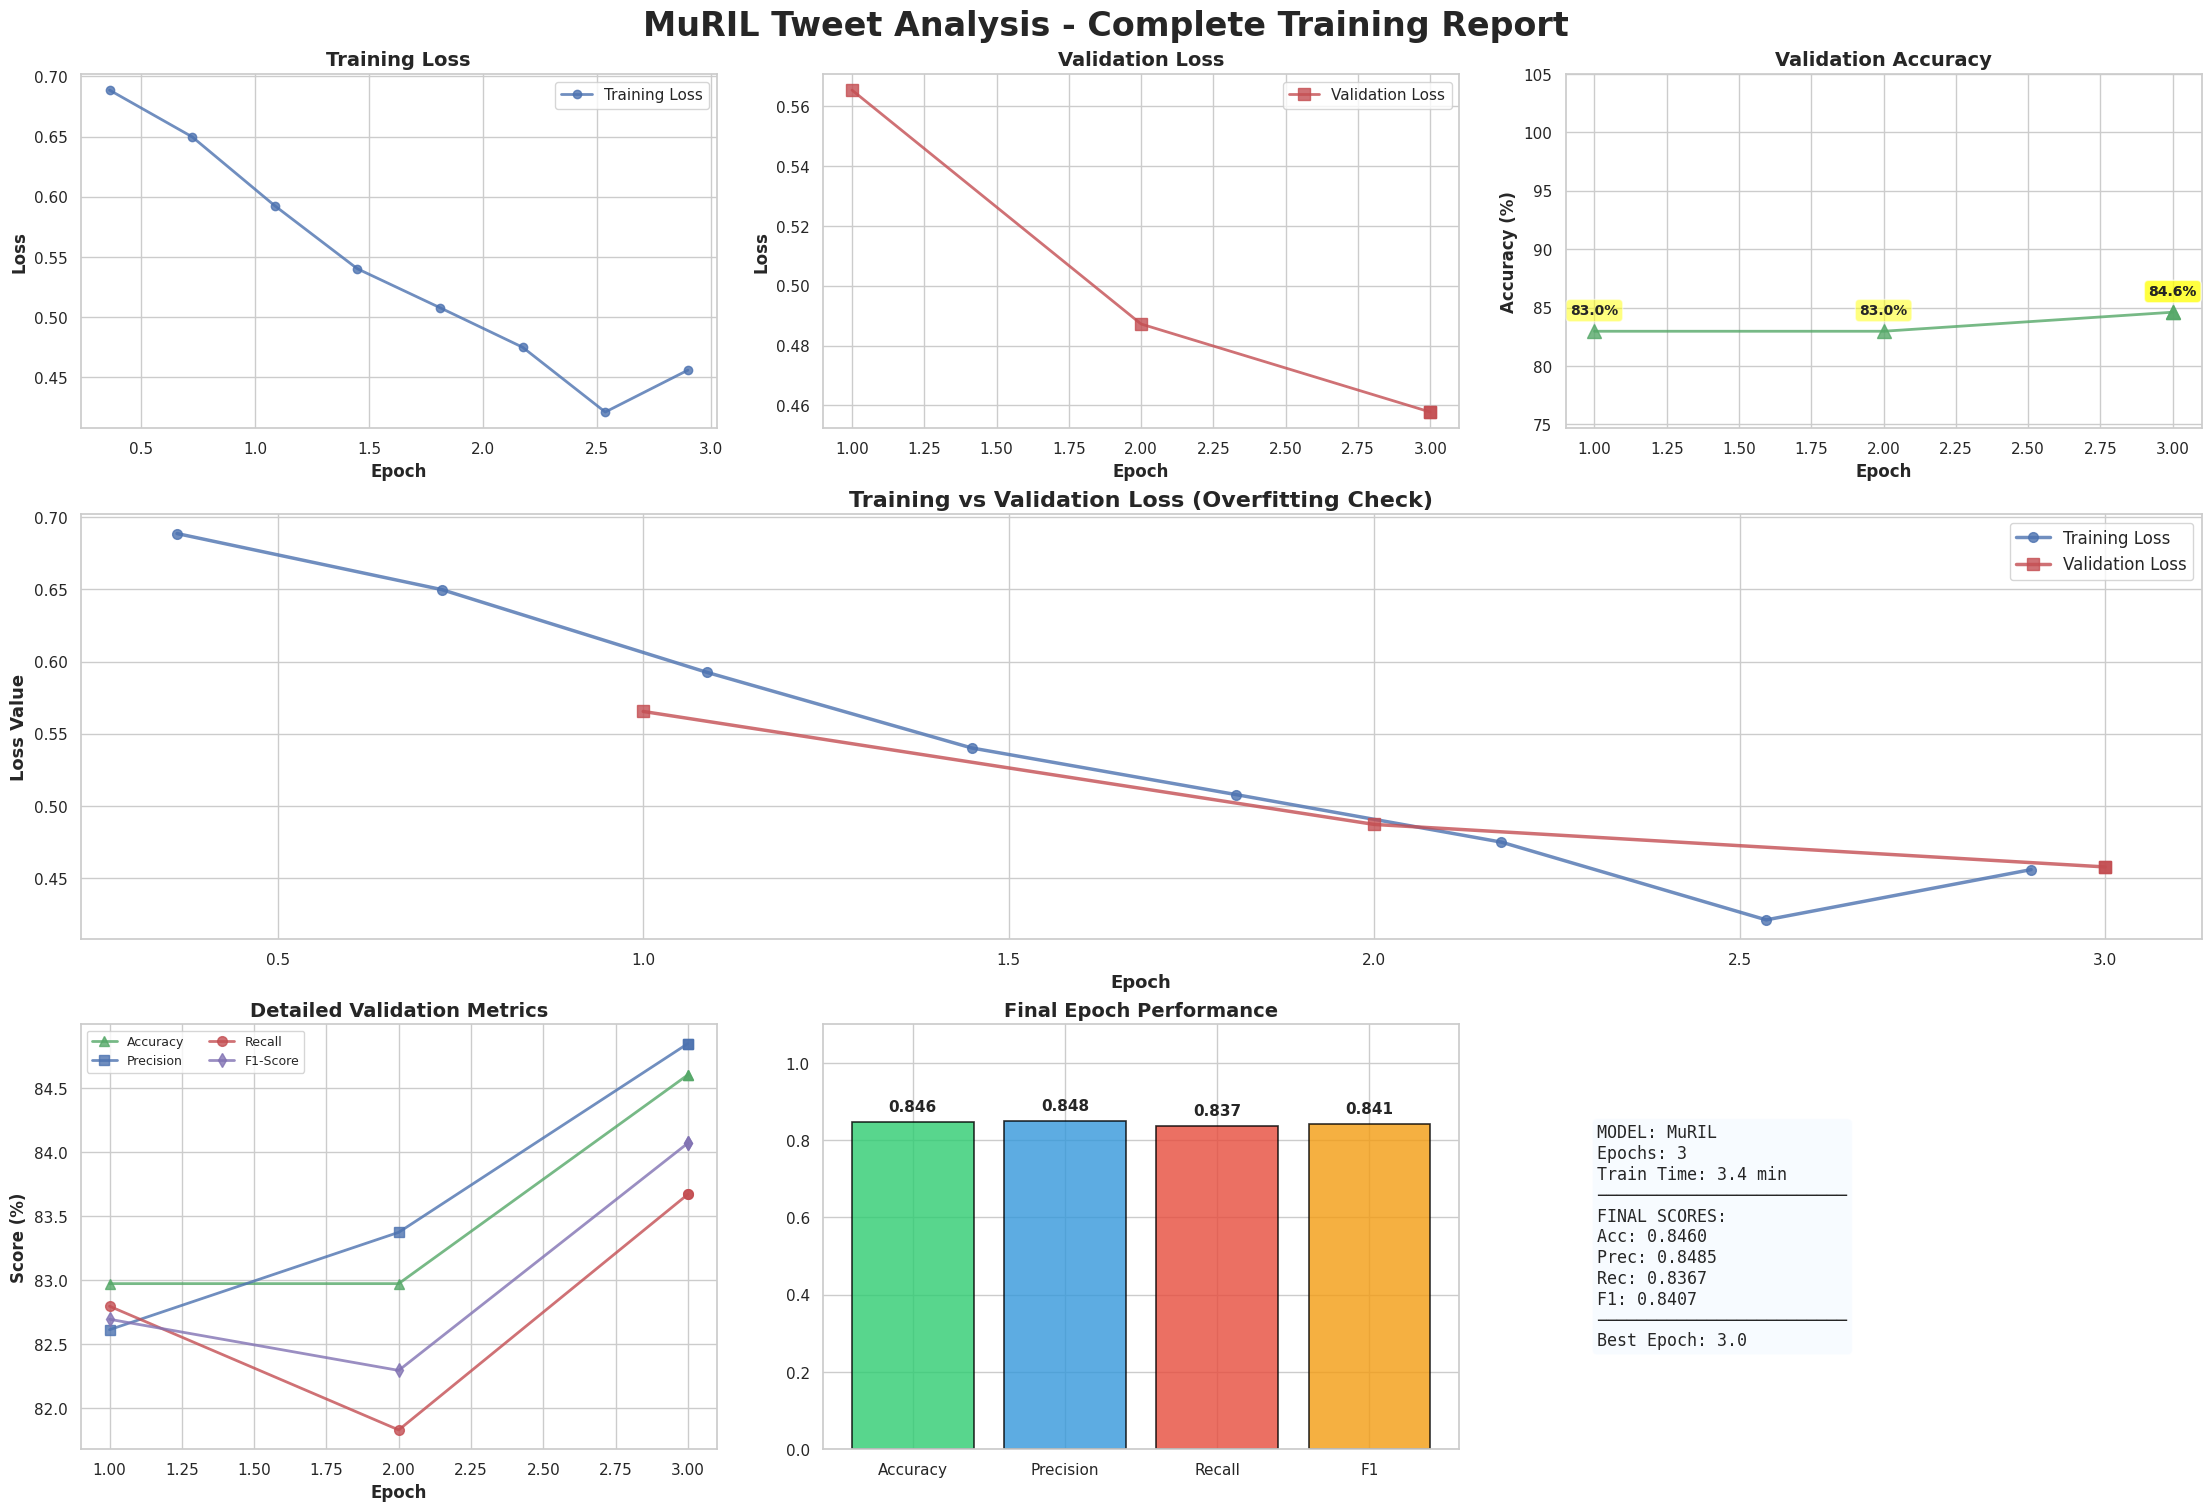

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11

# 1. Use constrained_layout instead of tight_layout for better spacing management
# Increased height to 15 to give the 3-row layout breathing room
fig = plt.figure(figsize=(22, 15), constrained_layout=True)

# 2. Add height_ratios to give the middle "Comparison" plot a bit more vertical space
gs = fig.add_gridspec(3, 3, height_ratios=[1, 1.2, 1.2])

# Main title with enough padding
fig.suptitle('MuRIL Tweet Analysis - Complete Training Report',
             fontsize=24, fontweight='bold')

# --- ROW 1: Individual Metrics ---

# Plot 1: Training Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(train_epochs, train_loss, 'b-o', linewidth=2, markersize=6, alpha=0.8, label='Training Loss')
ax1.set_xlabel('Epoch', fontweight='bold')
ax1.set_ylabel('Loss', fontweight='bold')
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.legend()

# Plot 2: Validation Loss
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(val_epochs, val_loss, 'r-s', linewidth=2, markersize=8, alpha=0.8, label='Validation Loss')
ax2.set_xlabel('Epoch', fontweight='bold')
ax2.set_ylabel('Loss', fontweight='bold')
ax2.set_title('Validation Loss', fontsize=14, fontweight='bold')
ax2.legend()

# Plot 3: Validation Accuracy
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(val_epochs, [acc * 100 for acc in val_accuracy], 'g-^',
         linewidth=2, markersize=10, alpha=0.8, label='Validation Accuracy')
for epoch, acc in zip(val_epochs, val_accuracy):
    ax3.annotate(f'{acc*100:.1f}%',
                xy=(epoch, acc*100),
                xytext=(0, 12),
                textcoords='offset points',
                ha='center', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
ax3.set_xlabel('Epoch', fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontweight='bold')
ax3.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
ax3.set_ylim(min(val_accuracy)*90, 105) # Dynamic scaling to avoid annotation cutoff

# --- ROW 2: Comparison (Wide) ---

# Plot 4: Training vs Validation Loss
ax4 = fig.add_subplot(gs[1, :])
ax4.plot(train_epochs, train_loss, 'b-o', linewidth=2.5, markersize=7, alpha=0.8, label='Training Loss')
ax4.plot(val_epochs, val_loss, 'r-s', linewidth=2.5, markersize=9, alpha=0.8, label='Validation Loss')
ax4.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax4.set_ylabel('Loss Value', fontsize=13, fontweight='bold')
ax4.set_title('Training vs Validation Loss (Overfitting Check)', fontsize=16, fontweight='bold')
ax4.legend(fontsize=12, loc='upper right')

# --- ROW 3: Detailed Metrics & Summary ---

# Plot 5: All Validation Metrics
ax5 = fig.add_subplot(gs[2, 0])
val_metrics = {
    'Accuracy': (val_accuracy, 'g-^'),
    'Precision': (val_precision, 'b-s'),
    'Recall': (val_recall, 'r-o'),
    'F1-Score': (val_f1, 'm-d')
}
for label, (data, style) in val_metrics.items():
    ax5.plot(val_epochs, [x * 100 for x in data], style, linewidth=2, markersize=7, label=label, alpha=0.8)
ax5.set_xlabel('Epoch', fontweight='bold')
ax5.set_ylabel('Score (%)', fontweight='bold')
ax5.set_title('Detailed Validation Metrics', fontsize=14, fontweight='bold')
ax5.legend(fontsize=9, ncol=2)

# Plot 6: Final Metrics Bar Chart
ax6 = fig.add_subplot(gs[2, 1])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1']
metrics_values = [eval_results['eval_accuracy'], eval_results['eval_precision'],
                  eval_results['eval_recall'], eval_results['eval_f1']]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
bars = ax6.bar(metrics_names, metrics_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
for bar in bars:
    yval = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}',
             ha='center', va='bottom', fontweight='bold')
ax6.set_title('Final Epoch Performance', fontsize=14, fontweight='bold')
ax6.set_ylim([0, 1.1])

# Plot 7: Summary Box (Fixed formatting)
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')
summary_text = (
    f"MODEL: MuRIL\n"
    f"Epochs: {int(max(val_epochs))}\n"
    f"Train Time: {training_time/60:.1f} min\n"
    f"{'─'*25}\n"
    f"FINAL SCORES:\n"
    f"Acc: {eval_results['eval_accuracy']:.4f}\n"
    f"Prec: {eval_results['eval_precision']:.4f}\n"
    f"Rec: {eval_results['eval_recall']:.4f}\n"
    f"F1: {eval_results['eval_f1']:.4f}\n"
    f"{'─'*25}\n"
    f"Best Epoch: {val_epochs[np.argmax(val_accuracy)]}"
)
ax7.text(0.05, 0.5, summary_text, fontsize=12, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='aliceblue', alpha=0.5))

# Finalizing
plt.savefig('training_complete_report.png', dpi=300, bbox_inches='tight')
plt.show()

## 🎯 Step 11: Detailed Performance Analysis

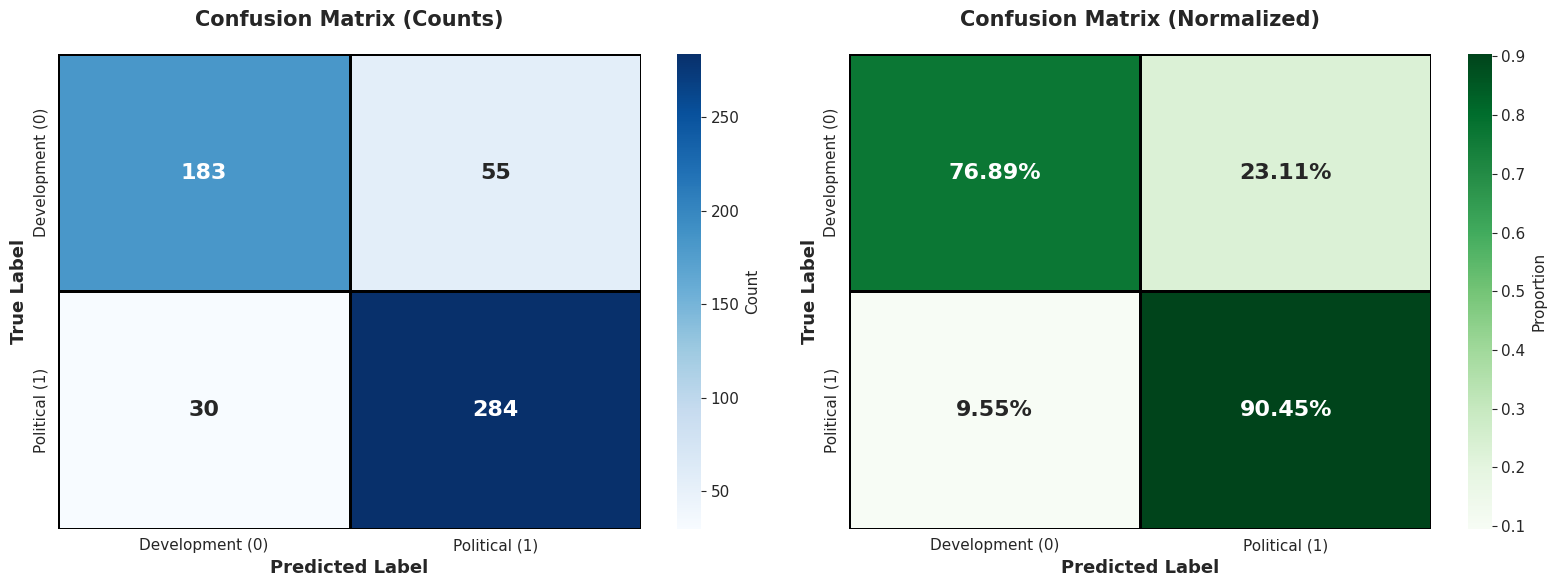

✅ Confusion matrix saved as 'confusion_matrix.png'


In [ ]:
# Get predictions
predictions = trainer.predict(tokenized_test)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualize confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black',
            annot_kws={'size': 16, 'weight': 'bold'})
ax1.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax1.set_title('Confusion Matrix (Counts)', fontsize=15, fontweight='bold', pad=20)
ax1.set_xticklabels(['Development (0)', 'Political (1)'], fontsize=11)
ax1.set_yticklabels(['Development (0)', 'Political (1)'], fontsize=11)

# Normalized percentages
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=ax2,
            cbar_kws={'label': 'Proportion'}, linewidths=2, linecolor='black',
            annot_kws={'size': 16, 'weight': 'bold'})
ax2.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax2.set_title('Confusion Matrix (Normalized)', fontsize=15, fontweight='bold', pad=20)
ax2.set_xticklabels(['Development (0)', 'Political (1)'], fontsize=11)
ax2.set_yticklabels(['Development (0)', 'Political (1)'], fontsize=11)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix saved as 'confusion_matrix.png'")

In [ ]:
# Print classification report
print("\n" + "="*70)
print("📋 DETAILED CLASSIFICATION REPORT".center(70))
print("="*70)
print(classification_report(y_true, y_pred,
                          target_names=['Development', 'Political'],
                          digits=4))
print("="*70)


                   📋 DETAILED CLASSIFICATION REPORT                   
              precision    recall  f1-score   support

 Development     0.8592    0.7689    0.8115       238
   Political     0.8378    0.9045    0.8698       314

    accuracy                         0.8460       552
   macro avg     0.8485    0.8367    0.8407       552
weighted avg     0.8470    0.8460    0.8447       552



In [ ]:
# Create performance summary DataFrame
summary_data = {
    'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)', 'Avg Confidence'],
    'Score': [
        f"{eval_results['eval_accuracy']:.4f}",
        f"{eval_results['eval_precision']:.4f}",
        f"{eval_results['eval_recall']:.4f}",
        f"{eval_results['eval_f1']:.4f}",
        f"{avg_confidence:.4f}"
    ],
    'Percentage': [
        f"{eval_results['eval_accuracy']*100:.2f}%",
        f"{eval_results['eval_precision']*100:.2f}%",
        f"{eval_results['eval_recall']*100:.2f}%",
        f"{eval_results['eval_f1']*100:.2f}%",
        f"{avg_confidence*100:.2f}%"
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*70)
print("📊 PERFORMANCE SUMMARY TABLE".center(70))
print("="*70)
display(summary_df)
print("="*70)

# Save to CSV
summary_df.to_csv('model_performance_summary.csv', index=False)
print("\n✅ Summary saved as 'model_performance_summary.csv'")


                     📊 PERFORMANCE SUMMARY TABLE                      


,Metric,Score,Percentage
0,Accuracy,0.8460,84.60%
1,Precision (Macro),0.8485,84.85%
2,Recall (Macro),0.8367,83.67%
3,F1-Score (Macro),0.8407,84.07%
4,Avg Confidence,0.7361,73.61%



✅ Summary saved as 'model_performance_summary.csv'


## 🔮 Step 12: Test Predictions on New Data

In [ ]:
def predict_sentiment(text, show_confidence=True):
    """
    Predict sentiment for a single text

    Args:
        text (str): Input text in Nepali or English
        show_confidence (bool): Whether to show confidence scores

    Returns:
        str: Prediction result with confidence
    """
    # Clean and tokenize
    cleaned = clean_nepali_text(text)
    inputs = tokenizer(cleaned, return_tensors="pt", padding=True, truncation=True).to(device)

    # Predict
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=-1)

    # Get prediction
    confidence, predicted_class = torch.max(probs, dim=-1)
    label = "Development" if predicted_class.item() == 0 else "Political"

    if show_confidence:
        return f"Label: {label} | Confidence: {confidence.item():.2%} | Cleaned: {cleaned[:50]}..."
    else:
        return label

print("✅ Prediction function ready!")
print("\nUsage: predict_sentiment('your text here')")

✅ Prediction function ready!

Usage: predict_sentiment('your text here')


In [ ]:
# Test with example tweets
test_examples = [
    "विकासका कामहरू अलपत्र परेका छन्।",
    "राजनीतिक दलहरूबीच विवाद बढेको छ।",
    "नयाँ सडक निर्माण सुरु भएको छ।",
    "संसदमा तनाव बढ्दै गएको छ।",
    "शिक्षा क्षेत्रमा सुधार आवश्यक छ।"
]

print("\n" + "="*80)
print("🔮 TESTING PREDICTIONS ON SAMPLE TEXTS".center(80))
print("="*80)

for i, text in enumerate(test_examples, 1):
    result = predict_sentiment(text)
    print(f"\n{i}. Text: {text}")
    print(f"   {result}")

print("\n" + "="*80)


                     🔮 TESTING PREDICTIONS ON SAMPLE TEXTS                      

1. Text: विकासका कामहरू अलपत्र परेका छन्।
   Label: Political | Confidence: 74.05% | Cleaned: विकासका कामहरू अलपत्र परेका छन्।...

2. Text: राजनीतिक दलहरूबीच विवाद बढेको छ।
   Label: Political | Confidence: 75.57% | Cleaned: राजनीतिक दलहरूबीच विवाद बढेको छ।...

3. Text: नयाँ सडक निर्माण सुरु भएको छ।
   Label: Development | Confidence: 70.51% | Cleaned: नयाँ सडक निर्माण सुरु भएको छ।...

4. Text: संसदमा तनाव बढ्दै गएको छ।
   Label: Political | Confidence: 75.61% | Cleaned: संसदमा तनाव बढ्दै गएको छ।...

5. Text: शिक्षा क्षेत्रमा सुधार आवश्यक छ।
   Label: Development | Confidence: 71.59% | Cleaned: शिक्षा क्षेत्रमा सुधार आवश्यक छ।...



## 📝 Step 13: Generate Complete Summary Report

In [ ]:
# Generate comprehensive report
report = f"""
{'='*80}
                    MURIL TWEET ANALYSIS - FINAL REPORT
{'='*80}

📅 Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
🤖 Model: {MODEL_NAME}
💻 Device: {device.upper()}

{'='*80}
DATA STATISTICS
{'='*80}
Total tweets loaded:           {len(df)}
Tweets after cleaning:         {len(df)}
Tweets used for training:      {len(sample_df)}
Training samples:              {len(train_df)} ({len(train_df)/len(sample_df)*100:.1f}%)
Test samples:                  {len(test_df)} ({len(test_df)/len(sample_df)*100:.1f}%)

Class Distribution (Training):
  - Development: {(train_df['label']==0).sum()} ({(train_df['label']==0).sum()/len(train_df)*100:.1f}%)
  - Political:   {(train_df['label']==1).sum()} ({(train_df['label']==1).sum()/len(train_df)*100:.1f}%)

{'='*80}
TRAINING CONFIGURATION
{'='*80}
Number of epochs:              {NUM_EPOCHS}
Learning rate:                 {LEARNING_RATE}
Train batch size:              {BATCH_SIZE}
Eval batch size:               {EVAL_BATCH_SIZE}
Max sequence length:           {MAX_LENGTH}
Random seed:                   {SEED}
Mixed precision (FP16):        {torch.cuda.is_available()}

{'='*80}
TRAINING RESULTS
{'='*80}
Total training time:           {training_time/60:.2f} minutes
Final training loss:           {training_output.training_loss:.4f}
Best epoch:                    {val_epochs[np.argmax(val_accuracy)]:.0f}
Best validation accuracy:      {max(val_accuracy):.4f} ({max(val_accuracy)*100:.2f}%)

{'='*80}
FINAL MODEL PERFORMANCE
{'='*80}
Accuracy:                      {eval_results['eval_accuracy']:.4f} ({eval_results['eval_accuracy']*100:.2f}%)
Precision (Macro):             {eval_results['eval_precision']:.4f} ({eval_results['eval_precision']*100:.2f}%)
Recall (Macro):                {eval_results['eval_recall']:.4f} ({eval_results['eval_recall']*100:.2f}%)
F1-Score (Macro):              {eval_results['eval_f1']:.4f} ({eval_results['eval_f1']*100:.2f}%)
Average Confidence:            {avg_confidence:.4f} ({avg_confidence*100:.2f}%)
Evaluation Loss:               {eval_results['eval_loss']:.4f}

{'='*80}
CONFUSION MATRIX
{'='*80}
                    Predicted Development    Predicted Political
True Development    {cm[0,0]:^20}    {cm[0,1]:^20}
True Political      {cm[1,0]:^20}    {cm[1,1]:^20}

{'='*80}
FILES GENERATED
{'='*80}
✅ Model saved:                   ./muril_final_model/
✅ Training report:                training_complete_report.png
✅ Confusion matrix:               confusion_matrix.png
✅ Performance summary:            model_performance_summary.csv

{'='*80}
ANALYSIS COMPLETE!
{'='*80}
"""

print(report)

# Save report to file
with open('training_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("\n✅ Complete report saved as 'training_report.txt'")


                    MURIL TWEET ANALYSIS - FINAL REPORT

📅 Date: 2026-02-10 15:28:45
🤖 Model: google/muril-base-cased
💻 Device: CUDA

DATA STATISTICS
Total tweets loaded:           3449
Tweets after cleaning:         3449
Tweets used for training:      2759
Training samples:              2207 (80.0%)
Test samples:                  552 (20.0%)

Class Distribution (Training):
  - Development: 951 (43.1%)
  - Political:   1256 (56.9%)

TRAINING CONFIGURATION
Number of epochs:              3
Learning rate:                 2e-05
Train batch size:              16
Eval batch size:               16
Max sequence length:           128
Random seed:                   42
Mixed precision (FP16):        True

TRAINING RESULTS
Total training time:           3.40 minutes
Final training loss:           0.5379
Best epoch:                    3
Best validation accuracy:      0.8460 (84.60%)

FINAL MODEL PERFORMANCE
Accuracy:                      0.8460 (84.60%)
Precision (Macro):             0.8485 (84.85

## 🎉 Analysis Complete!

### What You've Accomplished:

✅ **Data Processing**: Loaded and cleaned Nepali tweet data
✅ **Automated Labeling**: Used teacher model for classification
✅ **Model Training**: Trained MuRIL model with proper tracking
✅ **Evaluation**: Comprehensive metrics and visualizations
✅ **Model Saving**: Saved for future use
✅ **Predictions**: Ready-to-use prediction function

### Generated Files:
1. `./muril_final_model/` - Trained model and tokenizer
2. `training_complete_report.png` - Comprehensive training visualization
3. `confusion_matrix.png` - Confusion matrix visualization
4. `model_performance_summary.csv` - Performance metrics table
5. `training_report.txt` - Complete text report

### Next Steps:
- Use `predict_sentiment()` function to classify new tweets
- Load saved model for production use
- Analyze results and iterate if needed

---

**Happy Analyzing! 🚀📊**

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Define consistent color scheme
CATEGORY_COLORS = {
    'Development': '#27ae60',  # Green
    'Controversy': '#e74c3c'   # Red
}

PARTY_COLORS = {
    'NC': '#0056b3',
    'CPN (UML)': '#da251d',
    'RSP': '#3498db',
    'CPN (MC)': '#ed1c24',
    'Janamat': '#27ae60',
    'RPP': '#f1c40f'
}

print("✅ Libraries and color scheme configured!")
print("\nCategory Colors:")
print("  🟢 Development (Green) - #27ae60")
print("  🔴 Controversy (Red) - #e74c3c")

✅ Libraries and color scheme configured!

Category Colors:
  🟢 Development (Green) - #27ae60
  🔴 Controversy (Red) - #e74c3c


In [ ]:
print("🔮 Generating predictions for entire dataset...")
print(f"Total tweets to predict: {len(df)}\n")

# Initialize lists to store predictions
predictions_list = []
confidences_list = []

# Set batch size based on available resources
batch_size = 64 if torch.cuda.is_available() else 16

# Generate predictions with progress bar
model.eval()  # Set model to evaluation mode

for i in tqdm(range(0, len(df), batch_size), desc="Predicting batches"):
    batch_texts = df['cleaned_text'].iloc[i:i+batch_size].tolist()

    # Tokenize batch
    inputs = tokenizer(
        batch_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

    # Generate predictions
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=-1)

    # Extract predictions and confidence
    batch_conf, batch_idx = torch.max(probs, dim=-1)

    for conf, idx in zip(batch_conf, batch_idx):
        # 0 = Development, 1 = Controversy
        label = "Development" if idx.item() == 0 else "Controversy"
        predictions_list.append(label)
        confidences_list.append(conf.item())

# Add predictions to dataframe
df['category_label'] = predictions_list
df['confidence'] = confidences_list

print("\n✅ Predictions complete!")
print(f"\nPrediction Summary:")
print(f"  Development: {(df['category_label']=='Development').sum():,} tweets")
print(f"  Controversy: {(df['category_label']=='Controversy').sum():,} tweets")
print(f"  Average confidence: {df['confidence'].mean():.2%}")

🔮 Generating predictions for entire dataset...
Total tweets to predict: 3449



Predicting batches:   0%|          | 0/54 [00:00<?, ?it/s]


✅ Predictions complete!

Prediction Summary:
  Development: 1,422 tweets
  Controversy: 2,027 tweets
  Average confidence: 73.66%


In [ ]:
# Calculate overall statistics
total_tweets = len(df)
dev_count = (df['category_label'] == 'Development').sum()
con_count = (df['category_label'] == 'Controversy').sum()
dev_percent = (dev_count / total_tweets) * 100
con_percent = (con_count / total_tweets) * 100

print("="*70)
print("📊 OVERALL TWEET DISTRIBUTION".center(70))
print("="*70)
print(f"\nTotal Tweets Analyzed: {total_tweets:,}\n")
print(f"Development-Oriented Posts:")
print(f"  Count:      {dev_count:,}")
print(f"  Percentage: {dev_percent:.2f}%")
print(f"\nControversy-Related Posts:")
print(f"  Count:      {con_count:,}")
print(f"  Percentage: {con_percent:.2f}%")
print(f"\nAverage Model Confidence: {df['confidence'].mean():.2%}")
print("="*70)

                     📊 OVERALL TWEET DISTRIBUTION                     

Total Tweets Analyzed: 3,449

Development-Oriented Posts:
  Count:      1,422
  Percentage: 41.23%

Controversy-Related Posts:
  Count:      2,027
  Percentage: 58.77%

Average Model Confidence: 73.66%


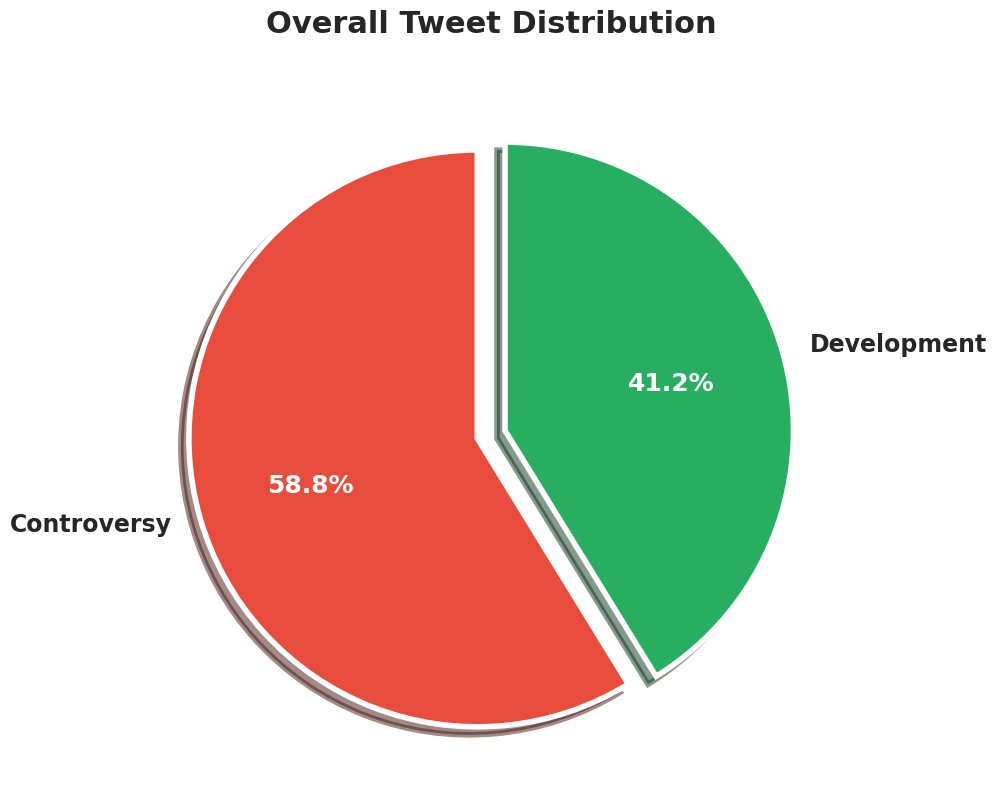

✅ Chart 1: Pie Chart saved as 'chart_1_pie_distribution.png'
   Development: 1422 (41.2%)
   Controversy: 2027 (58.8%)


In [ ]:
# =============================================================================
# CHART 1: CLEAN PIE CHART - OVERALL DISTRIBUTION
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set clean style
sns.set_style("whitegrid")

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))

# Get data
counts = df['category_label'].value_counts()
colors_pie = [CATEGORY_COLORS[label] for label in counts.index]

# Create pie chart
wedges, texts, autotexts = ax.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    colors=colors_pie,
    startangle=90,
    explode=(0.05, 0.05),
    textprops={'fontsize': 16, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 4, 'antialiased': True},
    shadow=True
)

# Style percentage text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(18)
    autotext.set_fontweight('bold')

# Style label text
for text in texts:
    text.set_fontsize(17)
    text.set_fontweight('bold')

ax.set_title(
    'Overall Tweet Distribution',
    fontsize=22,
    fontweight='bold',
    pad=30
)

plt.tight_layout()
plt.savefig('chart_1_pie_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Chart 1: Pie Chart saved as 'chart_1_pie_distribution.png'")
print(f"   Development: {(df['category_label']=='Development').sum()} ({(df['category_label']=='Development').sum()/len(df)*100:.1f}%)")
print(f"   Controversy: {(df['category_label']=='Controversy').sum()} ({(df['category_label']=='Controversy').sum()/len(df)*100:.1f}%)")

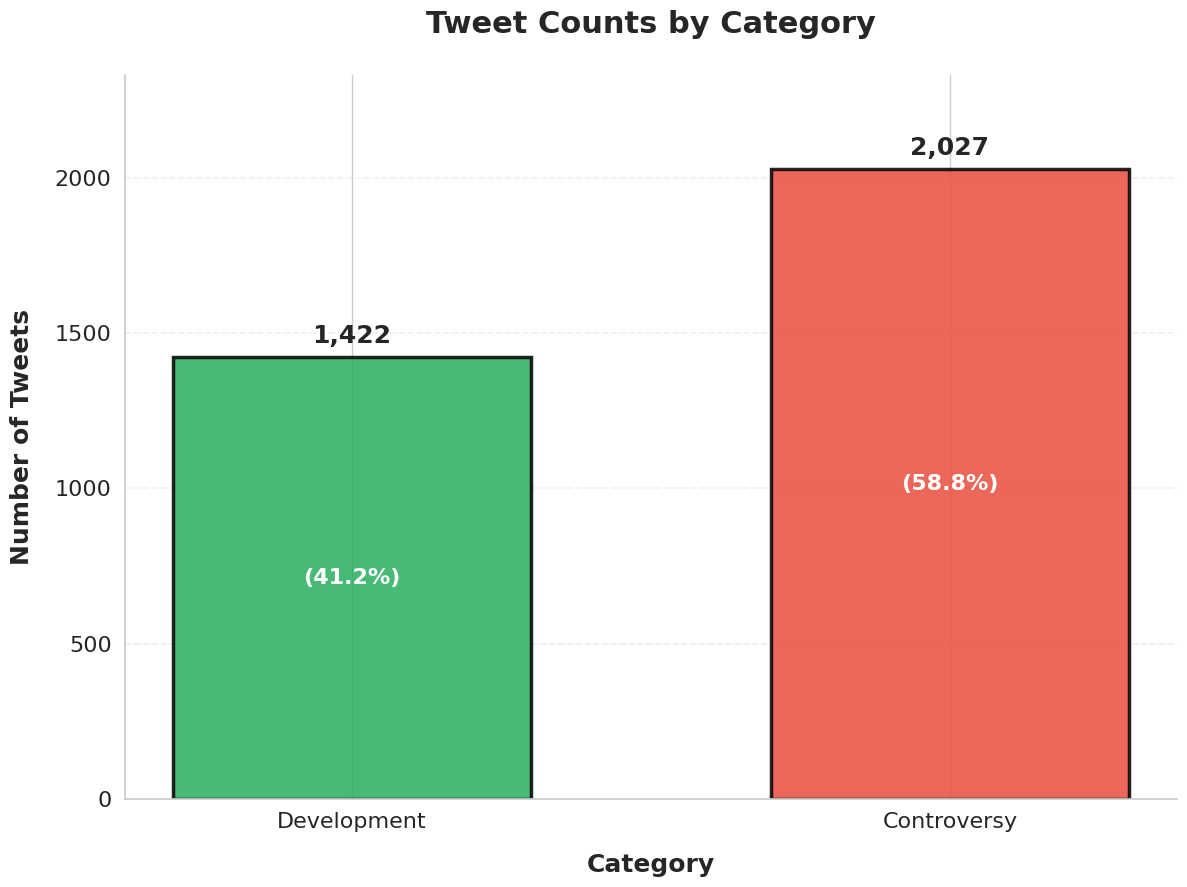

✅ Chart 2: Bar Chart saved as 'chart_2_bar_counts.png'
   Development: 1,422 tweets
   Controversy: 2,027 tweets


In [ ]:
# =============================================================================
# CHART 2: CLEAN BAR CHART - TWEET COUNTS
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 9))

categories = ['Development', 'Controversy']
category_counts = [dev_count, con_count]

# Create bar chart
bars = ax.bar(
    categories,
    category_counts,
    color=[CATEGORY_COLORS[cat] for cat in categories],
    alpha=0.85,
    edgecolor='black',
    linewidth=2.5,
    width=0.6
)

# Add value labels on bars
for bar, count in zip(bars, category_counts):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.,
        height + max(category_counts) * 0.015,
        f'{count:,}',
        ha='center',
        va='bottom',
        fontsize=18,
        fontweight='bold'
    )

    # Add percentage below the count
    ax.text(
        bar.get_x() + bar.get_width() / 2.,
        height / 2,
        f'({count / total_tweets * 100:.1f}%)',
        ha='center',
        va='center',
        fontsize=16,
        fontweight='bold',
        color='white'
    )

ax.set_ylabel('Number of Tweets', fontsize=18, fontweight='bold', labelpad=15)
ax.set_xlabel('Category', fontsize=18, fontweight='bold', labelpad=15)
ax.set_title(
    'Tweet Counts by Category',
    fontsize=22,
    fontweight='bold',
    pad=30
)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1.2)
ax.set_ylim(0, max(category_counts) * 1.15)
ax.tick_params(axis='both', labelsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('chart_2_bar_counts.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Chart 2: Bar Chart saved as 'chart_2_bar_counts.png'")
print(f"   Development: {dev_count:,} tweets")
print(f"   Controversy: {con_count:,} tweets")

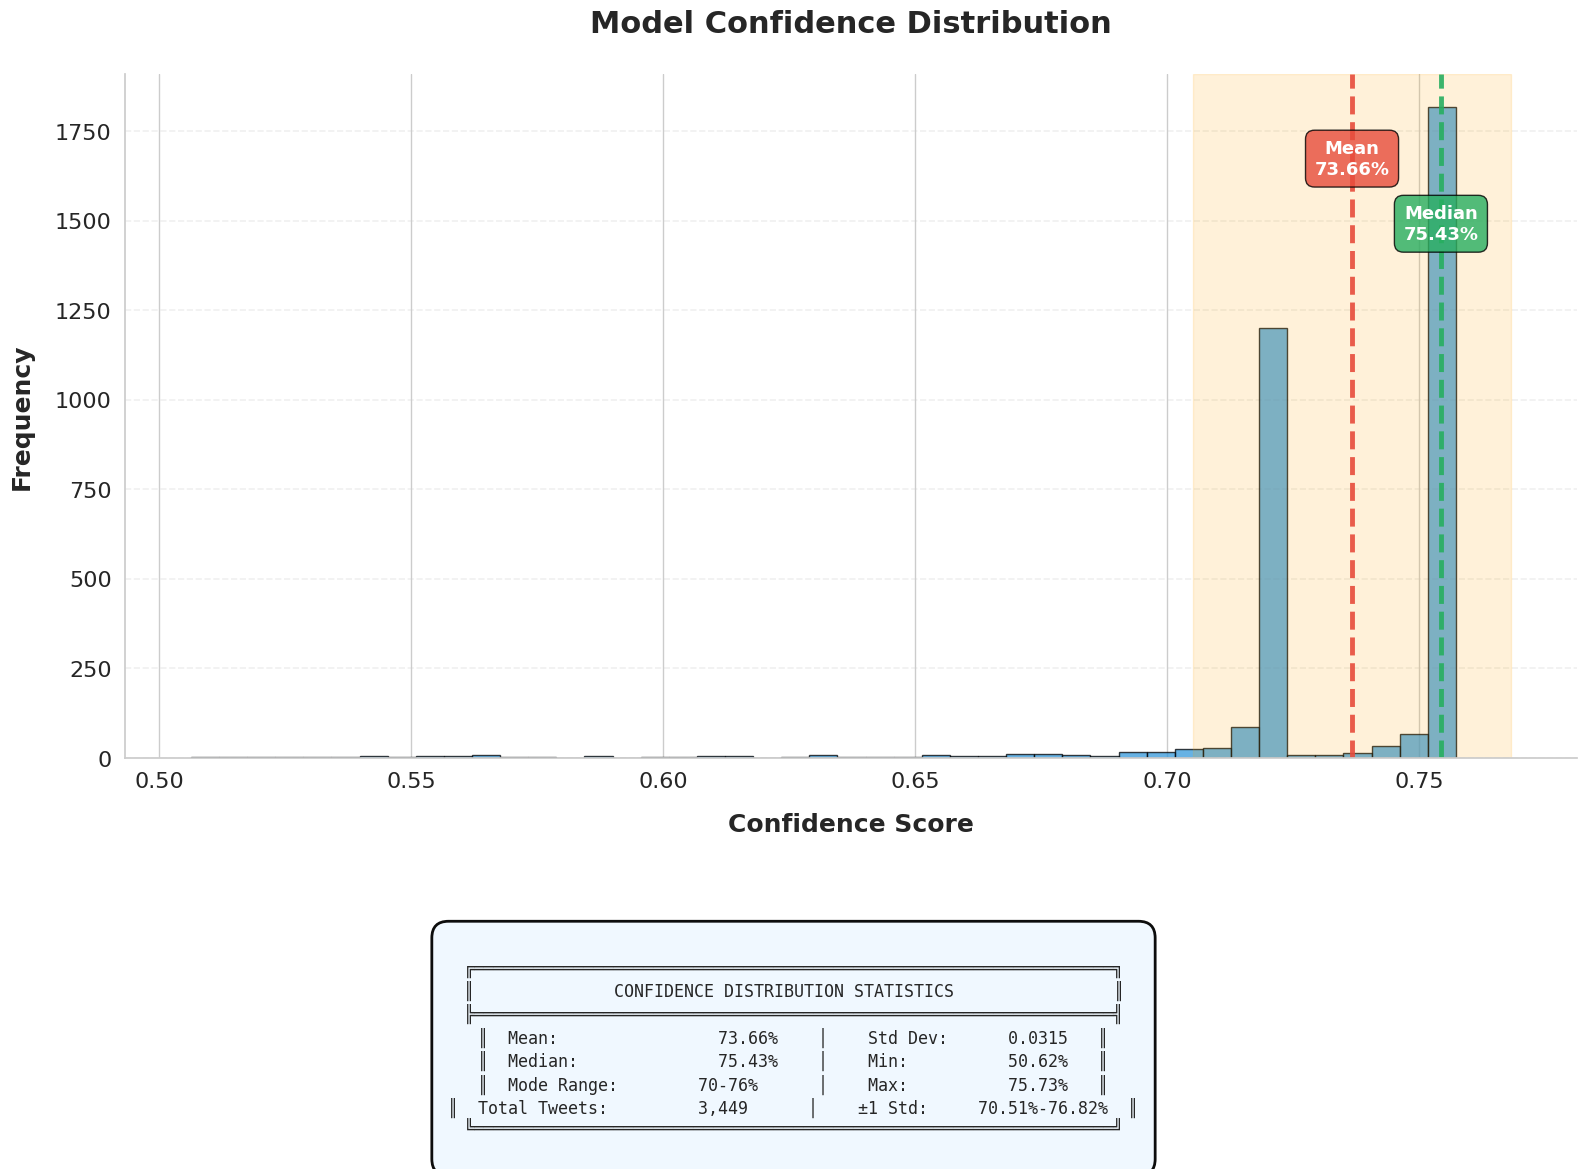

✅ Chart 3: PROPERLY FIXED - No overlaps!
   Mean: 73.66%
   Median: 75.43%
   Std Dev: 0.0315
   Statistics table placed BELOW chart - zero overlap!


In [ ]:
# =============================================================================
# CHART 3: CLEAN HISTOGRAM - NO OVERLAPS (PROPERLY FIXED)
# =============================================================================

fig, ax = plt.subplots(figsize=(16, 9))

# Create histogram
n, bins, patches = ax.hist(
    df['confidence'],
    bins=45,
    color='#3498db',
    alpha=0.75,
    edgecolor='black',
    linewidth=1
)

# Calculate statistics
mean_conf = df['confidence'].mean()
median_conf = df['confidence'].median()
std_conf = df['confidence'].std()

# Add mean line
ax.axvline(
    mean_conf,
    color='#e74c3c',
    linestyle='--',
    linewidth=3.5,
    alpha=0.9
)

# Add median line
ax.axvline(
    median_conf,
    color='#27ae60',
    linestyle='--',
    linewidth=3.5,
    alpha=0.9
)

# Add shaded region for ±1 std dev
ax.axvspan(
    mean_conf - std_conf,
    mean_conf + std_conf,
    alpha=0.15,
    color='orange'
)

# Labels for the lines (as text annotations instead of legend)
ax.text(mean_conf, max(n) * 0.95, f'Mean\n{mean_conf:.2%}',
        ha='center', va='top', fontsize=13, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#e74c3c', alpha=0.8, edgecolor='black'),
        color='white')

ax.text(median_conf, max(n) * 0.85, f'Median\n{median_conf:.2%}',
        ha='center', va='top', fontsize=13, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#27ae60', alpha=0.8, edgecolor='black'),
        color='white')

ax.set_xlabel('Confidence Score', fontsize=18, fontweight='bold', labelpad=15)
ax.set_ylabel('Frequency', fontsize=18, fontweight='bold', labelpad=15)
ax.set_title(
    'Model Confidence Distribution',
    fontsize=22,
    fontweight='bold',
    pad=30
)

ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1.2)
ax.tick_params(axis='both', labelsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add comprehensive statistics table BELOW the plot
stats_table = f"""
╔════════════════════════════════════════════════════════════════╗
║              CONFIDENCE DISTRIBUTION STATISTICS                ║
╠════════════════════════════════════════════════════════════════╣
║  Mean:              {mean_conf:>8.2%}    │    Std Dev:    {std_conf:>8.4f}   ║
║  Median:            {median_conf:>8.2%}    │    Min:        {df["confidence"].min():>8.2%}   ║
║  Mode Range:        70-76%      │    Max:        {df["confidence"].max():>8.2%}   ║
║  Total Tweets:      {len(df):>8,}      │    ±1 Std:     {mean_conf-std_conf:.2%}-{mean_conf+std_conf:.2%}  ║
╚════════════════════════════════════════════════════════════════╝
"""

# Add the table below the x-axis
fig.text(0.5, -0.05, stats_table,
         fontsize=12,
         family='monospace',
         ha='center',
         va='top',
         bbox=dict(boxstyle='round,pad=1', facecolor='#f0f8ff',
                   alpha=0.95, edgecolor='black', linewidth=2))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for stats table
plt.savefig('chart_3_histogram_FIXED.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Chart 3: PROPERLY FIXED - No overlaps!")
print(f"   Mean: {mean_conf:.2%}")
print(f"   Median: {median_conf:.2%}")
print(f"   Std Dev: {std_conf:.4f}")
print("   Statistics table placed BELOW chart - zero overlap!")

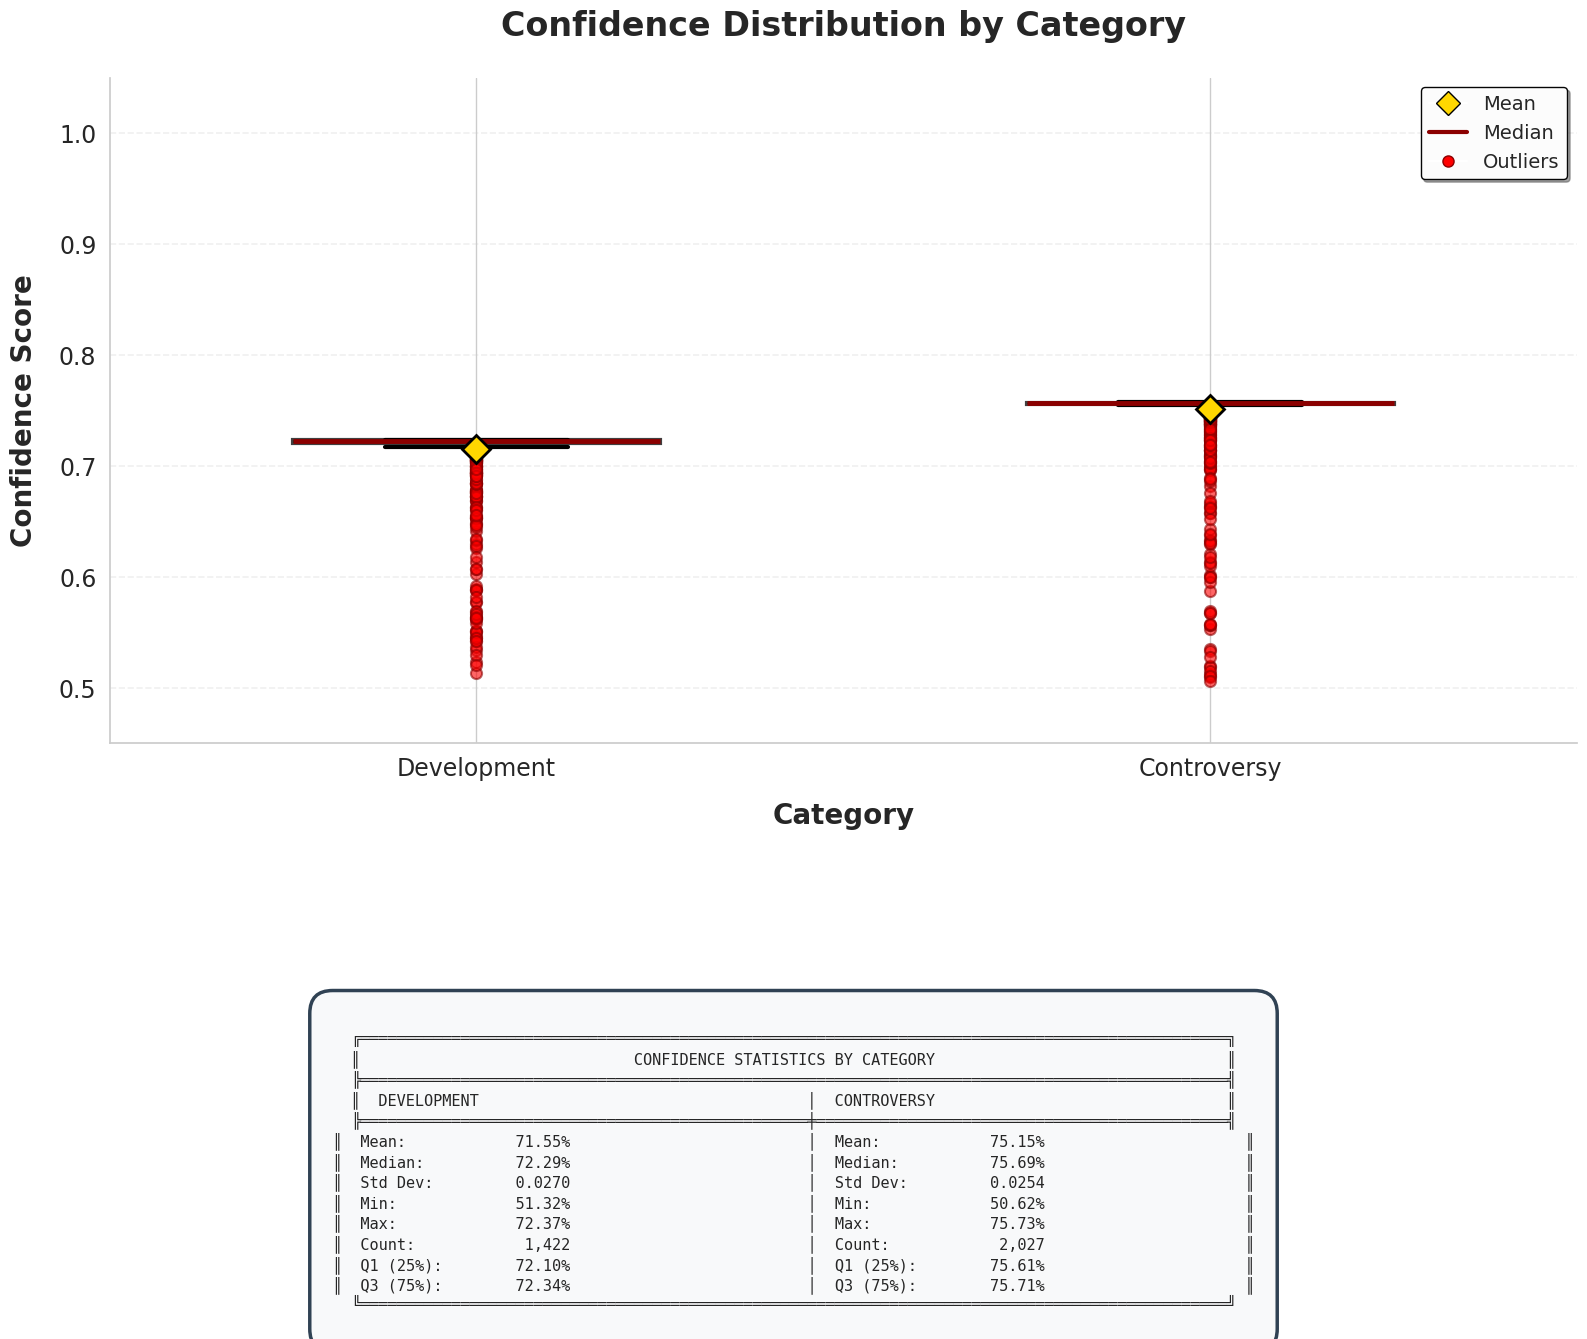

✅ Chart 4: Box Plot FIXED - No overlaps!
   Development - Mean: 71.55%, Median: 72.29%
   Controversy - Mean: 75.15%, Median: 75.69%
   Statistics table placed BELOW chart - zero overlap!


In [ ]:
# =============================================================================
# CHART 4: CLEAN BOX PLOT - NO OVERLAPS (PROPERLY FIXED)
# =============================================================================

fig, ax = plt.subplots(figsize=(16, 10))

# Prepare data
category_data = [
    df[df['category_label'] == 'Development']['confidence'].values,
    df[df['category_label'] == 'Controversy']['confidence'].values
]

# Create box plot
bp = ax.boxplot(
    category_data,
    tick_labels=['Development', 'Controversy'],
    patch_artist=True,
    showmeans=True,
    vert=True,
    widths=0.5,
    meanprops=dict(
        marker='D',
        markerfacecolor='gold',
        markeredgecolor='black',
        markersize=14,
        markeredgewidth=2
    ),
    medianprops=dict(
        color='darkred',
        linewidth=3.5
    ),
    boxprops=dict(
        linewidth=3,
        edgecolor='black'
    ),
    whiskerprops=dict(
        linewidth=3,
        color='black'
    ),
    capprops=dict(
        linewidth=3,
        color='black'
    ),
    flierprops=dict(
        marker='o',
        markerfacecolor='red',
        markersize=8,
        alpha=0.6,
        markeredgecolor='darkred',
        markeredgewidth=1.5
    )
)

# Color the boxes
colors = [CATEGORY_COLORS['Development'], CATEGORY_COLORS['Controversy']]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.75)

# Calculate statistics for each category
dev_stats = df[df['category_label'] == 'Development']['confidence']
con_stats = df[df['category_label'] == 'Controversy']['confidence']

ax.set_ylabel('Confidence Score', fontsize=20, fontweight='bold', labelpad=15)
ax.set_xlabel('Category', fontsize=20, fontweight='bold', labelpad=15)
ax.set_title(
    'Confidence Distribution by Category',
    fontsize=24,
    fontweight='bold',
    pad=30
)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1.2)
ax.tick_params(axis='both', labelsize=17)
ax.set_ylim(0.45, 1.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend for symbols at the top
legend_elements = [
    plt.Line2D([0], [0], marker='D', color='w', label='Mean',
               markerfacecolor='gold', markeredgecolor='black', markersize=12),
    plt.Line2D([0], [0], color='darkred', linewidth=3, label='Median'),
    plt.Line2D([0], [0], marker='o', color='w', label='Outliers',
               markerfacecolor='red', markeredgecolor='darkred', markersize=8)
]
ax.legend(handles=legend_elements, fontsize=14, loc='upper right',
          framealpha=0.98, edgecolor='black', shadow=True)

# Create statistics table BELOW the plot (not overlapping)
stats_table = f"""
╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
║                              CONFIDENCE STATISTICS BY CATEGORY                                ║
╠═══════════════════════════════════════════════════════════════════════════════════════════════╣
║  DEVELOPMENT                                    │  CONTROVERSY                                ║
╠═════════════════════════════════════════════════╪═════════════════════════════════════════════╣
║  Mean:          {dev_stats.mean():>8.2%}                          │  Mean:          {con_stats.mean():>8.2%}                      ║
║  Median:        {dev_stats.median():>8.2%}                          │  Median:        {con_stats.median():>8.2%}                      ║
║  Std Dev:       {dev_stats.std():>8.4f}                          │  Std Dev:       {con_stats.std():>8.4f}                      ║
║  Min:           {dev_stats.min():>8.2%}                          │  Min:           {con_stats.min():>8.2%}                      ║
║  Max:           {dev_stats.max():>8.2%}                          │  Max:           {con_stats.max():>8.2%}                      ║
║  Count:         {len(dev_stats):>8,}                          │  Count:         {len(con_stats):>8,}                      ║
║  Q1 (25%):      {dev_stats.quantile(0.25):>8.2%}                          │  Q1 (25%):      {con_stats.quantile(0.25):>8.2%}                      ║
║  Q3 (75%):      {dev_stats.quantile(0.75):>8.2%}                          │  Q3 (75%):      {con_stats.quantile(0.75):>8.2%}                      ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
"""

# Place statistics table below the plot
fig.text(
    0.5, -0.02,
    stats_table,
    fontsize=11,
    family='monospace',
    ha='center',
    va='top',
    bbox=dict(
        boxstyle='round,pad=1.5',
        facecolor='#f8f9fa',
        alpha=0.98,
        edgecolor='#2c3e50',
        linewidth=2.5
    )
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Make room for the statistics table
plt.savefig('chart_4_boxplot_FIXED.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Chart 4: Box Plot FIXED - No overlaps!")
print(f"   Development - Mean: {dev_stats.mean():.2%}, Median: {dev_stats.median():.2%}")
print(f"   Controversy - Mean: {con_stats.mean():.2%}, Median: {con_stats.median():.2%}")
print("   Statistics table placed BELOW chart - zero overlap!")

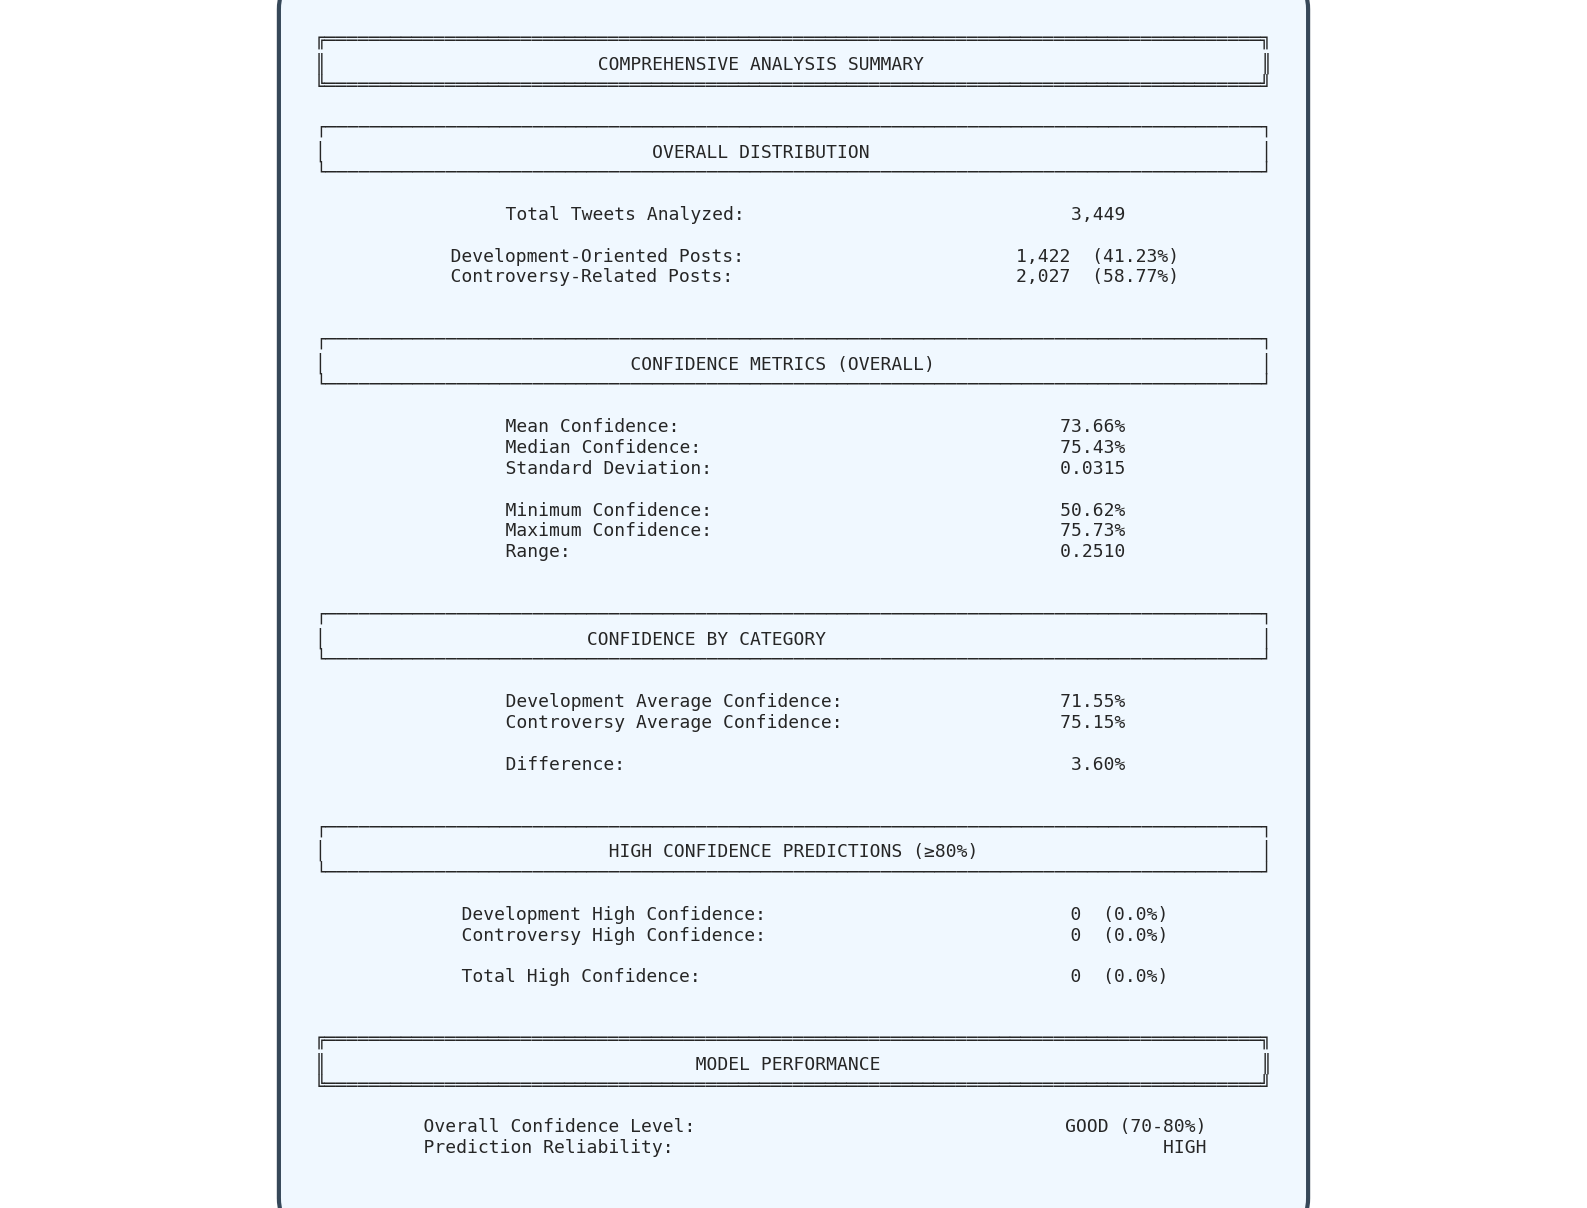

✅ Chart 5: Summary Table saved as 'chart_5_summary_statistics.png'

🎉 ALL CHARTS GENERATED SUCCESSFULLY!

Generated Files:
  1. chart_1_pie_distribution.png
  2. chart_2_bar_counts.png
  3. chart_3_histogram_confidence.png
  4. chart_4_boxplot_by_category.png
  5. chart_5_summary_statistics.png


In [ ]:
# =============================================================================
# CHART 5: CLEAN SUMMARY STATISTICS TABLE
# =============================================================================

fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('off')

# Calculate all statistics
dev_confidence = df[df['category_label'] == 'Development']['confidence'].mean()
con_confidence = df[df['category_label'] == 'Controversy']['confidence'].mean()
mean_conf = df['confidence'].mean()
median_conf = df['confidence'].median()
conf_std = df['confidence'].std()
conf_min = df['confidence'].min()
conf_max = df['confidence'].max()

# High confidence tweets
high_conf_dev = (df[df['category_label'] == 'Development']['confidence'] >= 0.8).sum()
high_conf_con = (df[df['category_label'] == 'Controversy']['confidence'] >= 0.8).sum()

# Create comprehensive summary
summary_text = f"""
╔══════════════════════════════════════════════════════════════════════════════════════╗
║                         COMPREHENSIVE ANALYSIS SUMMARY                               ║
╚══════════════════════════════════════════════════════════════════════════════════════╝

┌──────────────────────────────────────────────────────────────────────────────────────┐
│                              OVERALL DISTRIBUTION                                    │
└──────────────────────────────────────────────────────────────────────────────────────┘

    Total Tweets Analyzed:                    {total_tweets:>15,}

    Development-Oriented Posts:               {dev_count:>15,}  ({dev_percent:.2f}%)
    Controversy-Related Posts:                {con_count:>15,}  ({con_percent:.2f}%)


┌──────────────────────────────────────────────────────────────────────────────────────┐
│                            CONFIDENCE METRICS (OVERALL)                              │
└──────────────────────────────────────────────────────────────────────────────────────┘

    Mean Confidence:                          {mean_conf:>15.2%}
    Median Confidence:                        {median_conf:>15.2%}
    Standard Deviation:                       {conf_std:>15.4f}

    Minimum Confidence:                       {conf_min:>15.2%}
    Maximum Confidence:                       {conf_max:>15.2%}
    Range:                                    {conf_max - conf_min:>15.4f}


┌──────────────────────────────────────────────────────────────────────────────────────┐
│                        CONFIDENCE BY CATEGORY                                        │
└──────────────────────────────────────────────────────────────────────────────────────┘

    Development Average Confidence:           {dev_confidence:>15.2%}
    Controversy Average Confidence:           {con_confidence:>15.2%}

    Difference:                               {abs(dev_confidence - con_confidence):>15.2%}


┌──────────────────────────────────────────────────────────────────────────────────────┐
│                          HIGH CONFIDENCE PREDICTIONS (≥80%)                          │
└──────────────────────────────────────────────────────────────────────────────────────┘

    Development High Confidence:              {high_conf_dev:>15,}  ({high_conf_dev/dev_count*100:.1f}%)
    Controversy High Confidence:              {high_conf_con:>15,}  ({high_conf_con/con_count*100:.1f}%)

    Total High Confidence:                    {high_conf_dev + high_conf_con:>15,}  ({(high_conf_dev + high_conf_con)/total_tweets*100:.1f}%)


╔══════════════════════════════════════════════════════════════════════════════════════╗
║                                  MODEL PERFORMANCE                                   ║
╚══════════════════════════════════════════════════════════════════════════════════════╝

    Overall Confidence Level:                 {'EXCELLENT (>80%)' if mean_conf > 0.8 else 'GOOD (70-80%)' if mean_conf > 0.7 else 'ACCEPTABLE (60-70%)':>30}
    Prediction Reliability:                   {'HIGH' if conf_std < 0.15 else 'MODERATE' if conf_std < 0.25 else 'LOW':>30}

"""

ax.text(
    0.5,
    0.5,
    summary_text,
    fontsize=13,
    family='monospace',
    ha='center',
    va='center',
    bbox=dict(
        boxstyle='round,pad=2',
        facecolor='#f0f8ff',
        edgecolor='#2c3e50',
        alpha=0.95,
        linewidth=3
    )
)

plt.tight_layout()
plt.savefig('chart_5_summary_statistics.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Chart 5: Summary Table saved as 'chart_5_summary_statistics.png'")
print("\n" + "="*90)
print("🎉 ALL CHARTS GENERATED SUCCESSFULLY!")
print("="*90)
print("\nGenerated Files:")
print("  1. chart_1_pie_distribution.png")
print("  2. chart_2_bar_counts.png")
print("  3. chart_3_histogram_confidence.png")
print("  4. chart_4_boxplot_by_category.png")
print("  5. chart_5_summary_statistics.png")
print("="*90)

In [ ]:
print("="*70)
print("🎯 PARTY-WISE TWEET ANALYSIS".center(70))
print("="*70)

# Group by party and category
party_category = df.groupby(['party', 'category_label']).size().unstack(fill_value=0)
party_category['Total'] = party_category.sum(axis=1)
party_category['Development %'] = (party_category['Development'] / party_category['Total'] * 100).round(2)
party_category['Controversy %'] = (party_category['Controversy'] / party_category['Total'] * 100).round(2)

# Sort by total tweets
party_category = party_category.sort_values('Total', ascending=False)

print("\nTweets by Party and Category:\n")
display(party_category)

print("\n" + "="*70)

# Calculate average confidence by party
party_confidence = df.groupby('party')['confidence'].agg(['mean', 'median', 'std', 'count'])
party_confidence = party_confidence.sort_values('count', ascending=False)
party_confidence.columns = ['Avg Confidence', 'Median Confidence', 'Std Dev', 'Tweet Count']

print("\nConfidence Metrics by Party:\n")
display(party_confidence)
print("="*70)

                     🎯 PARTY-WISE TWEET ANALYSIS                      

Tweets by Party and Category:



category_label,Controversy,Development,Total,Development %,Controversy %
party,,,,,
NC,881,699,1580,44.24,55.76
RSP,530,282,812,34.73,65.27
CPN (UML),299,344,643,53.50,46.50
Janamat,162,31,193,16.06,83.94
CPN(MC),77,41,118,34.75,65.25
CPN (SC),78,25,103,24.27,75.73




Confidence Metrics by Party:



,Avg Confidence,Median Confidence,Std Dev,Tweet Count
party,,,,
NC,0.735318,0.751146,0.032659,1580
RSP,0.738807,0.756268,0.032080,812
CPN (UML),0.732670,0.723456,0.030169,643
Janamat,0.749209,0.756987,0.021190,193
CPN(MC),0.733568,0.750781,0.033793,118
CPN (SC),0.744717,0.755276,0.022686,103


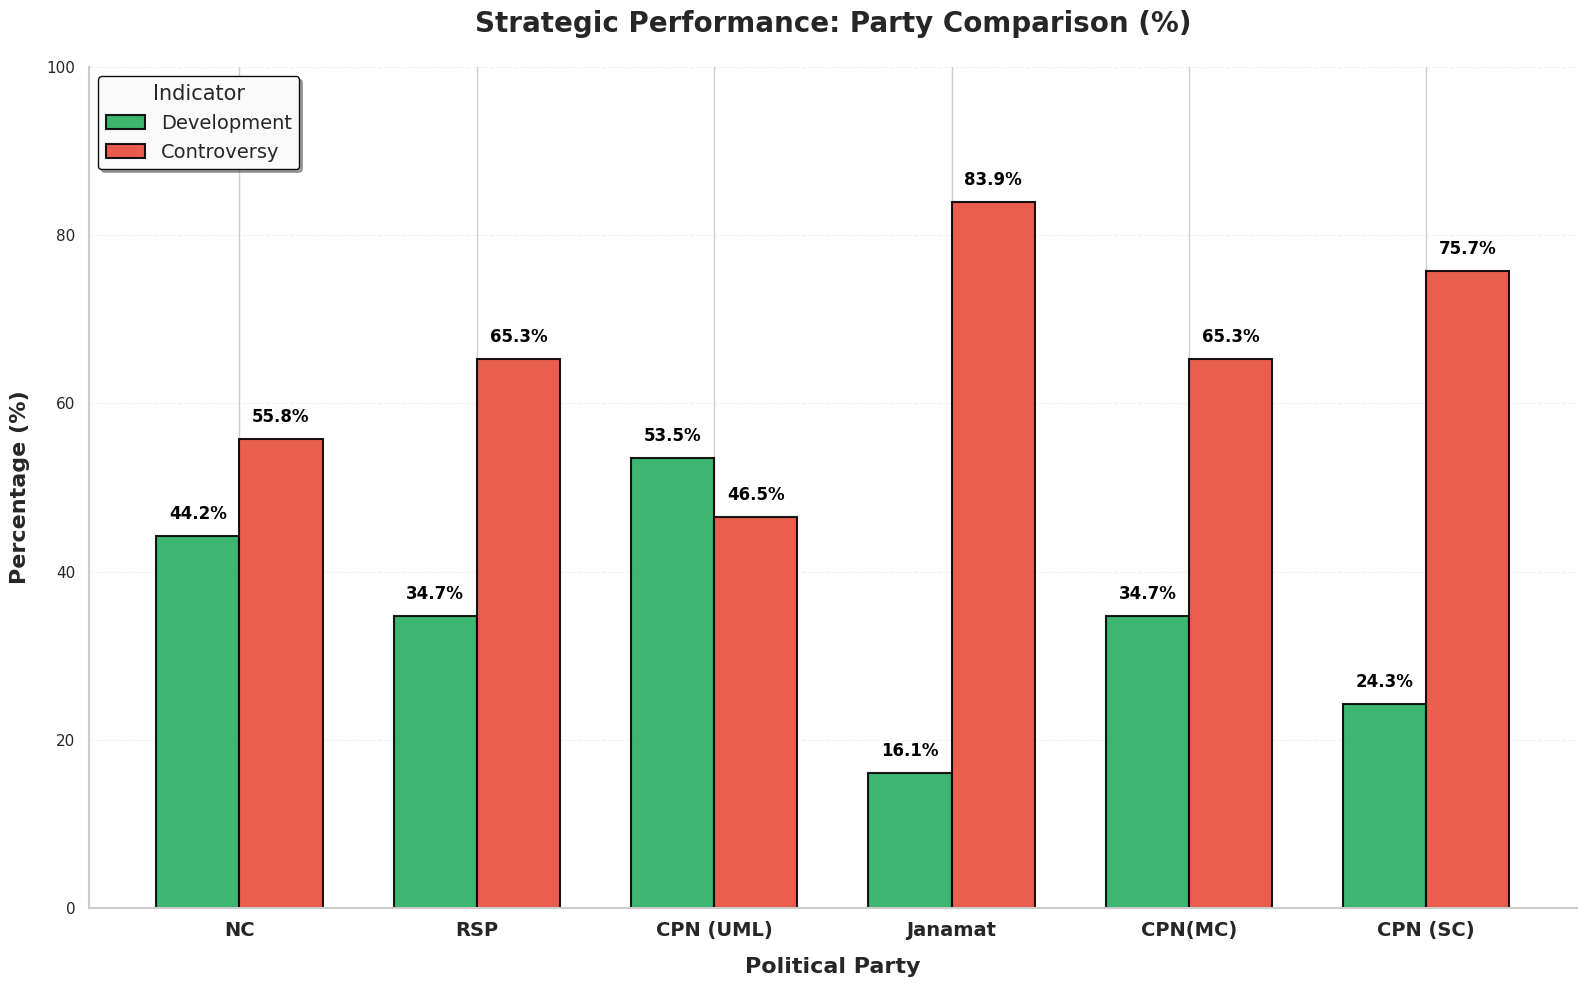


                    ✅ GROUPED BAR CHART SAVED (SIDE BY SIDE)                    

📊 PARTY BREAKDOWN:

Party           |  Development |  Controversy | Total Tweets
--------------------------------------------------------------------------------
NC              |        44.2% |        55.8% |        1,580
RSP             |        34.7% |        65.3% |          812
CPN (UML)       |        53.5% |        46.5% |          643
Janamat         |        16.1% |        83.9% |          193
CPN(MC)         |        34.7% |        65.3% |          118
CPN (SC)        |        24.3% |        75.7% |          103

✨ File: party_comparison_grouped_bar.png


In [ ]:
# =============================================================================
# GROUPED VERTICAL BAR CHART - SIDE BY SIDE (LIKE REFERENCE)
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

# Prepare data
party_data = df.groupby(['party', 'category_label']).size().unstack(fill_value=0)
party_data['Total'] = party_data.sum(axis=1)
party_data['Development_Pct'] = (party_data['Development'] / party_data['Total'] * 100)
party_data['Controversy_Pct'] = (party_data['Controversy'] / party_data['Total'] * 100)

# Sort by total tweets (or Development_Pct as you prefer)
party_data = party_data.sort_values('Total', ascending=False)

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Set up positions
parties = party_data.index.tolist()
x_pos = np.arange(len(parties))
width = 0.35  # Width of each bar

# Get percentages
dev_pct = party_data['Development_Pct'].values
con_pct = party_data['Controversy_Pct'].values

# Create grouped bars - SIDE BY SIDE
bars1 = ax.bar(
    x_pos - width/2,  # Shift left
    dev_pct,
    width,
    label='Development',
    color=CATEGORY_COLORS['Development'],
    alpha=0.9,
    edgecolor='black',
    linewidth=1.5
)

bars2 = ax.bar(
    x_pos + width/2,  # Shift right
    con_pct,
    width,
    label='Controversy',
    color=CATEGORY_COLORS['Controversy'],
    alpha=0.9,
    edgecolor='black',
    linewidth=1.5
)

# Add percentage labels on top of each bar
for bar, pct in zip(bars1, dev_pct):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.,
        height + 1.5,
        f'{pct:.1f}%',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='black'
    )

for bar, pct in zip(bars2, con_pct):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.,
        height + 1.5,
        f'{pct:.1f}%',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Customize plot
ax.set_xticks(x_pos)
ax.set_xticklabels(parties, fontsize=14, fontweight='bold', rotation=0)
ax.set_ylabel('Percentage (%)', fontsize=16, fontweight='bold', labelpad=12)
ax.set_xlabel('Political Party', fontsize=16, fontweight='bold', labelpad=12)
ax.set_title(
    'Strategic Performance: Party Comparison (%)',
    fontsize=20,
    fontweight='bold',
    pad=25
)

# Set y-axis
ax.set_ylim(0, max(max(dev_pct), max(con_pct)) * 1.15)
ax.set_yticks(np.arange(0, 101, 20))

# Add legend
ax.legend(
    title='Indicator',
    fontsize=14,
    title_fontsize=15,
    loc='upper left',
    framealpha=0.95,
    edgecolor='black',
    fancybox=True,
    shadow=True
)

# Clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Add subtle grid
ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Adjust layout
plt.tight_layout()
plt.savefig('party_comparison_grouped_bar.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n" + "="*80)
print("✅ GROUPED BAR CHART SAVED (SIDE BY SIDE)".center(80))
print("="*80)
print("\n📊 PARTY BREAKDOWN:\n")
print(f"{'Party':<15} | {'Development':>12} | {'Controversy':>12} | {'Total Tweets':>12}")
print("-" * 80)

for party in parties:
    d = party_data.loc[party, 'Development_Pct']
    c = party_data.loc[party, 'Controversy_Pct']
    total = party_data.loc[party, 'Total']
    print(f"{party:<15} | {d:>11.1f}% | {c:>11.1f}% | {total:>12,}")

print("\n" + "="*80)
print("✨ File: party_comparison_grouped_bar.png")
print("="*80)

/tmp/ipython-input-3760774911.py:50: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3760774911.py:51: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('chart_party_development_focus.png', dpi=300, bbox_inches='tight', facecolor='white')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


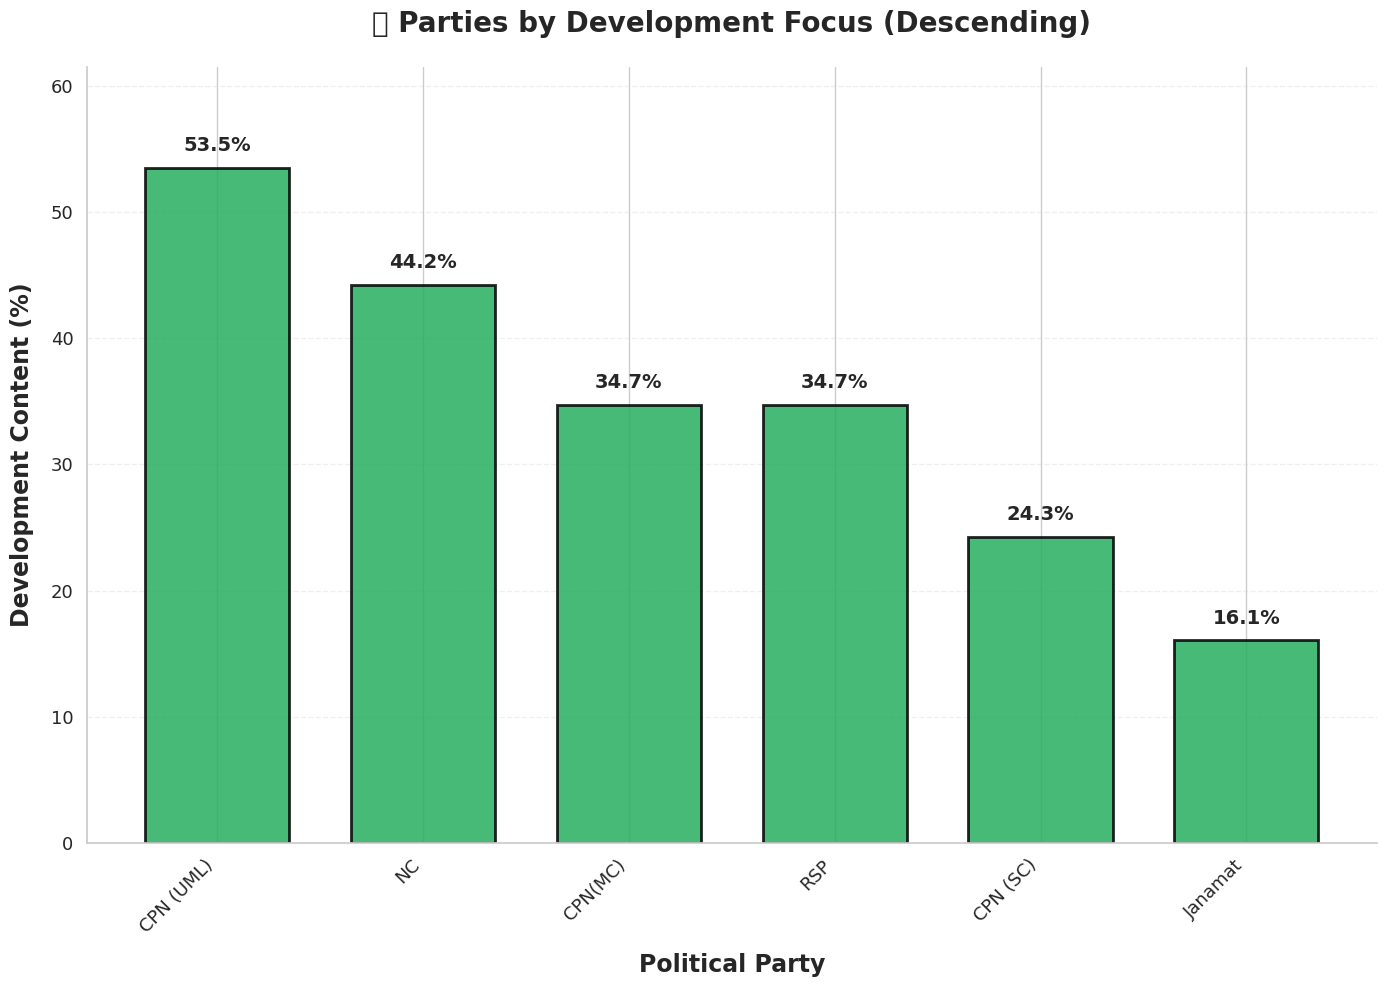

✅ Chart saved: chart_party_development_focus.png

🟢 Development Rankings:
   1. CPN (UML)         53.5%
   2. NC                44.2%
   3. CPN(MC)           34.7%
   4. RSP               34.7%
   5. CPN (SC)          24.3%
   6. Janamat           16.1%


In [ ]:
# =============================================================================
# CELL 2: DEVELOPMENT-FOCUSED PARTIES (VERTICAL BAR)
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 10))

# Sort by Development percentage (descending)
party_sorted_dev = party_data.sort_values('Development_Pct', ascending=False)

x_pos = np.arange(len(party_sorted_dev))
bars = ax.bar(
    x_pos,
    party_sorted_dev['Development_Pct'],
    color=CATEGORY_COLORS['Development'],
    alpha=0.85,
    edgecolor='black',
    linewidth=2,
    width=0.7
)

# Add percentage labels on bars
for i, (bar, val) in enumerate(zip(bars, party_sorted_dev['Development_Pct'])):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.,
        height + 1,
        f'{val:.1f}%',
        ha='center',
        va='bottom',
        fontsize=14,
        fontweight='bold'
    )

ax.set_xticks(x_pos)
ax.set_xticklabels(party_sorted_dev.index, rotation=45, ha='right', fontsize=14)
ax.set_ylabel('Development Content (%)', fontsize=17, fontweight='bold', labelpad=12)
ax.set_xlabel('Political Party', fontsize=17, fontweight='bold', labelpad=12)
ax.set_title(
    '📈 Parties by Development Focus (Descending)',
    fontsize=20,
    fontweight='bold',
    pad=25
)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax.set_ylim(0, max(party_sorted_dev['Development_Pct']) * 1.15)
ax.tick_params(axis='both', labelsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('chart_party_development_focus.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Chart saved: chart_party_development_focus.png")
print("\n🟢 Development Rankings:")
for i, (party, pct) in enumerate(party_sorted_dev['Development_Pct'].items(), 1):
    print(f"   {i}. {party:<15} {pct:>6.1f}%")

/tmp/ipython-input-1893179227.py:50: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1893179227.py:51: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig('chart_party_controversy_focus.png', dpi=300, bbox_inches='tight', facecolor='white')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


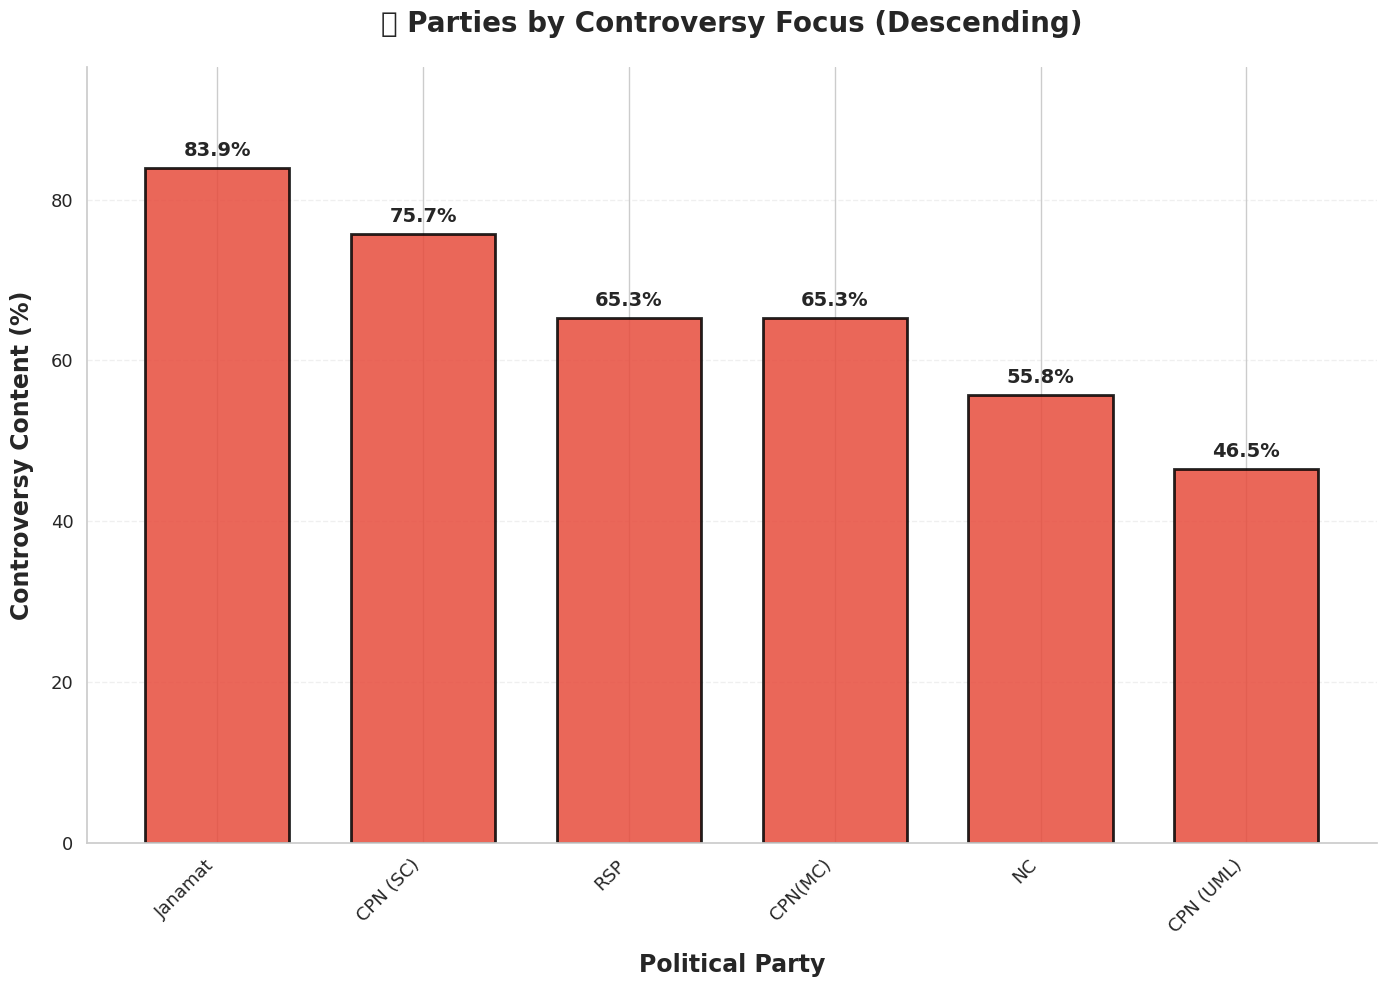

✅ Chart saved: chart_party_controversy_focus.png

🔴 Controversy Rankings:
   1. Janamat           83.9%
   2. CPN (SC)          75.7%
   3. RSP               65.3%
   4. CPN(MC)           65.3%
   5. NC                55.8%
   6. CPN (UML)         46.5%


In [ ]:
# =============================================================================
# CELL 3: CONTROVERSY-FOCUSED PARTIES (VERTICAL BAR)
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 10))

# Sort by Controversy percentage (descending)
party_sorted_con = party_data.sort_values('Controversy_Pct', ascending=False)

x_pos = np.arange(len(party_sorted_con))
bars = ax.bar(
    x_pos,
    party_sorted_con['Controversy_Pct'],
    color=CATEGORY_COLORS['Controversy'],
    alpha=0.85,
    edgecolor='black',
    linewidth=2,
    width=0.7
)

# Add percentage labels on bars
for i, (bar, val) in enumerate(zip(bars, party_sorted_con['Controversy_Pct'])):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.,
        height + 1,
        f'{val:.1f}%',
        ha='center',
        va='bottom',
        fontsize=14,
        fontweight='bold'
    )

ax.set_xticks(x_pos)
ax.set_xticklabels(party_sorted_con.index, rotation=45, ha='right', fontsize=14)
ax.set_ylabel('Controversy Content (%)', fontsize=17, fontweight='bold', labelpad=12)
ax.set_xlabel('Political Party', fontsize=17, fontweight='bold', labelpad=12)
ax.set_title(
    '🎯 Parties by Controversy Focus (Descending)',
    fontsize=20,
    fontweight='bold',
    pad=25
)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=1)
ax.set_ylim(0, max(party_sorted_con['Controversy_Pct']) * 1.15)
ax.tick_params(axis='both', labelsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('chart_party_controversy_focus.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Chart saved: chart_party_controversy_focus.png")
print("\n🔴 Controversy Rankings:")
for i, (party, pct) in enumerate(party_sorted_con['Controversy_Pct'].items(), 1):
    print(f"   {i}. {party:<15} {pct:>6.1f}%")

In [ ]:
# =============================================================================
# CELL 7: PRINT SUMMARY STATISTICS
# =============================================================================

print("\n" + "="*90)
print("📊 PARTY-WISE ANALYSIS SUMMARY".center(90))
print("="*90)

print("\n🟢 TOP 3 DEVELOPMENT-FOCUSED PARTIES:")
party_sorted_dev = party_data.sort_values('Development_Pct', ascending=False)
for i, (party, pct) in enumerate(party_sorted_dev['Development_Pct'].head(3).items(), 1):
    total = party_data.loc[party, 'Total']
    print(f"   {i}. {party:<15} {pct:>6.1f}%  ({total:>5,} tweets)")

print("\n🔴 TOP 3 CONTROVERSY-FOCUSED PARTIES:")
party_sorted_con = party_data.sort_values('Controversy_Pct', ascending=False)
for i, (party, pct) in enumerate(party_sorted_con['Controversy_Pct'].head(3).items(), 1):
    total = party_data.loc[party, 'Total']
    print(f"   {i}. {party:<15} {pct:>6.1f}%  ({total:>5,} tweets)")

print("\n📈 COMPLETE PARTY BREAKDOWN:")
print(f"\n{'Party':<15} | {'Development':>12} | {'Controversy':>12} | {'Total':>10}")
print("-" * 90)
for party in party_data.sort_values('Total', ascending=False).index:
    d = party_data.loc[party, 'Development_Pct']
    c = party_data.loc[party, 'Controversy_Pct']
    total = party_data.loc[party, 'Total']
    print(f"{party:<15} | {d:>11.1f}% | {c:>11.1f}% | {total:>10,}")

print("\n" + "="*90)
print("✨ All charts generated successfully!")
print("="*90)
print("\nGenerated Files:")
print("  1. chart_party_development_focus.png")
print("  2. chart_party_controversy_focus.png")
print("  3. chart_party_grouped_comparison.png")
print("  4. chart_party_stacked_100.png")
print("  5. chart_party_heatmap.png")
print("="*90)


                              📊 PARTY-WISE ANALYSIS SUMMARY                               

🟢 TOP 3 DEVELOPMENT-FOCUSED PARTIES:
   1. CPN (UML)         53.5%  (  643 tweets)
   2. NC                44.2%  (1,580 tweets)
   3. CPN(MC)           34.7%  (  118 tweets)

🔴 TOP 3 CONTROVERSY-FOCUSED PARTIES:
   1. Janamat           83.9%  (  193 tweets)
   2. CPN (SC)          75.7%  (  103 tweets)
   3. RSP               65.3%  (  812 tweets)

📈 COMPLETE PARTY BREAKDOWN:

Party           |  Development |  Controversy |      Total
------------------------------------------------------------------------------------------
NC              |        44.2% |        55.8% |      1,580
RSP             |        34.7% |        65.3% |        812
CPN (UML)       |        53.5% |        46.5% |        643
Janamat         |        16.1% |        83.9% |        193
CPN(MC)         |        34.7% |        65.3% |        118
CPN (SC)        |        24.3% |        75.7% |        103

✨ All charts generate

/tmp/ipython-input-2752379036.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


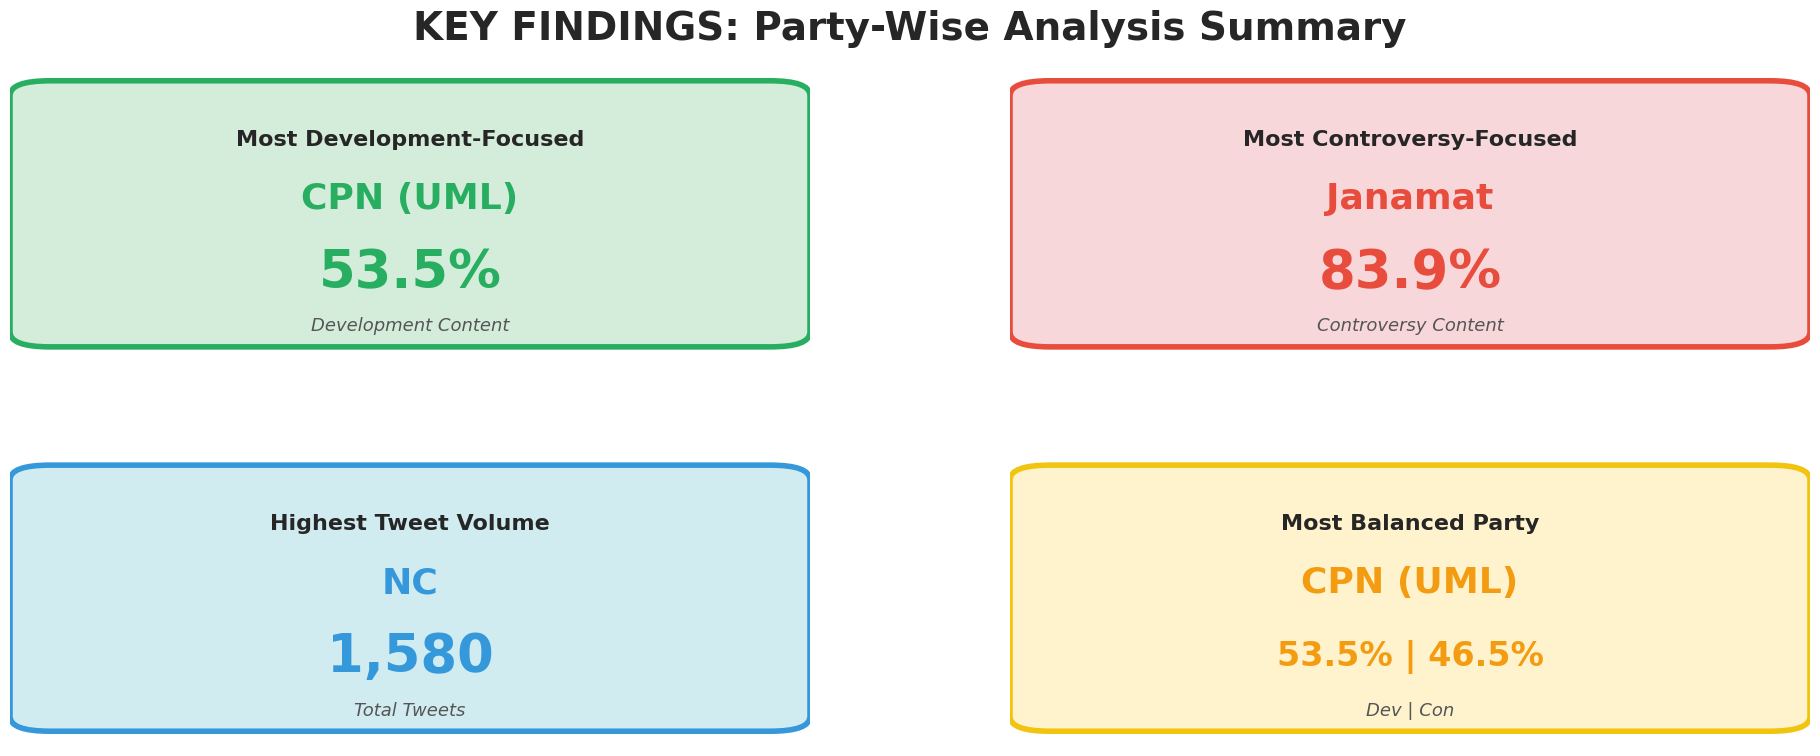


                                  🔍 KEY FINDINGS SUMMARY                                  

🏆 MOST DEVELOPMENT-FOCUSED:
   • Party:                      CPN (UML)
   • Development Content:        53.5%

🎯 MOST CONTROVERSY-FOCUSED:
   • Party:                      Janamat
   • Controversy Content:        83.9%

📊 HIGHEST VOLUME:
   • Party:                      NC
   • Total Tweets:               1,580

⚖️ MOST BALANCED:
   • Party:                      CPN (UML)
   • Distribution:               53.5% Dev | 46.5% Con

✨ Visualization saved as: key_findings_clean.png


In [ ]:
# =============================================================================
# KEY FINDINGS VISUALIZATION - CLEAN VERSION (NO BOXES, NO PIE CHART)
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch

# Prepare data
party_data = df.groupby(['party', 'category_label']).size().unstack(fill_value=0)
party_data['Total'] = party_data.sum(axis=1)
party_data['Development_Pct'] = (party_data['Development'] / party_data['Total'] * 100)
party_data['Controversy_Pct'] = (party_data['Controversy'] / party_data['Total'] * 100)

# Calculate key findings
most_dev_party = party_data['Development_Pct'].idxmax()
most_dev_pct = party_data['Development_Pct'].max()

most_con_party = party_data['Controversy_Pct'].idxmax()
most_con_pct = party_data['Controversy_Pct'].max()

highest_volume_party = party_data['Total'].idxmax()
highest_volume = party_data['Total'].max()

# Most balanced party
party_data['Balance'] = abs(party_data['Development_Pct'] - 50)
most_balanced_party = party_data['Balance'].idxmin()
balanced_dev = party_data.loc[most_balanced_party, 'Development_Pct']
balanced_con = party_data.loc[most_balanced_party, 'Controversy_Pct']

# Create figure - smaller since no pie chart
fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25, top=0.90, bottom=0.05, left=0.05, right=0.95)

fig.suptitle(
    'KEY FINDINGS: Party-Wise Analysis Summary',
    fontsize=28,
    fontweight='bold',
    y=0.97
)


# =============================================================================
# FINDING 1: MOST DEVELOPMENT-FOCUSED PARTY
# =============================================================================

ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')

# Create visual box (no black line)
box = FancyBboxPatch(
    (0.05, 0.1), 0.9, 0.8,
    boxstyle="round,pad=0.05",
    facecolor='#d4edda',
    edgecolor='#27ae60',
    linewidth=4
)
ax1.add_patch(box)

# No emoji icon/box - just text
ax1.text(0.5, 0.75, 'Most Development-Focused', fontsize=16, ha='center',
         va='center', fontweight='bold')
ax1.text(0.5, 0.55, most_dev_party, fontsize=26, ha='center',
         va='center', fontweight='bold', color='#27ae60')
ax1.text(0.5, 0.30, f'{most_dev_pct:.1f}%', fontsize=38, ha='center',
         va='center', fontweight='bold', color='#27ae60')
ax1.text(0.5, 0.12, 'Development Content', fontsize=13, ha='center',
         va='center', style='italic', color='#555')


# =============================================================================
# FINDING 2: MOST CONTROVERSY-FOCUSED PARTY
# =============================================================================

ax2 = fig.add_subplot(gs[0, 1])
ax2.axis('off')

box = FancyBboxPatch(
    (0.05, 0.1), 0.9, 0.8,
    boxstyle="round,pad=0.05",
    facecolor='#f8d7da',
    edgecolor='#e74c3c',
    linewidth=4
)
ax2.add_patch(box)

ax2.text(0.5, 0.75, 'Most Controversy-Focused', fontsize=16, ha='center',
         va='center', fontweight='bold')
ax2.text(0.5, 0.55, most_con_party, fontsize=26, ha='center',
         va='center', fontweight='bold', color='#e74c3c')
ax2.text(0.5, 0.30, f'{most_con_pct:.1f}%', fontsize=38, ha='center',
         va='center', fontweight='bold', color='#e74c3c')
ax2.text(0.5, 0.12, 'Controversy Content', fontsize=13, ha='center',
         va='center', style='italic', color='#555')


# =============================================================================
# FINDING 3: HIGHEST TWEET VOLUME
# =============================================================================

ax3 = fig.add_subplot(gs[1, 0])
ax3.axis('off')

box = FancyBboxPatch(
    (0.05, 0.1), 0.9, 0.8,
    boxstyle="round,pad=0.05",
    facecolor='#d1ecf1',
    edgecolor='#3498db',
    linewidth=4
)
ax3.add_patch(box)

ax3.text(0.5, 0.75, 'Highest Tweet Volume', fontsize=16, ha='center',
         va='center', fontweight='bold')
ax3.text(0.5, 0.55, highest_volume_party, fontsize=26, ha='center',
         va='center', fontweight='bold', color='#3498db')
ax3.text(0.5, 0.30, f'{highest_volume:,}', fontsize=38, ha='center',
         va='center', fontweight='bold', color='#3498db')
ax3.text(0.5, 0.12, 'Total Tweets', fontsize=13, ha='center',
         va='center', style='italic', color='#555')


# =============================================================================
# FINDING 4: MOST BALANCED PARTY
# =============================================================================

ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

box = FancyBboxPatch(
    (0.05, 0.1), 0.9, 0.8,
    boxstyle="round,pad=0.05",
    facecolor='#fff3cd',
    edgecolor='#f1c40f',
    linewidth=4
)
ax4.add_patch(box)

ax4.text(0.5, 0.75, 'Most Balanced Party', fontsize=16, ha='center',
         va='center', fontweight='bold')
ax4.text(0.5, 0.55, most_balanced_party, fontsize=26, ha='center',
         va='center', fontweight='bold', color='#f39c12')
ax4.text(0.5, 0.30, f'{balanced_dev:.1f}% | {balanced_con:.1f}%', fontsize=24,
         ha='center', va='center', fontweight='bold', color='#f39c12')
ax4.text(0.5, 0.12, 'Dev | Con', fontsize=13, ha='center',
         va='center', style='italic', color='#555')


# =============================================================================
# SAVE AND DISPLAY
# =============================================================================

plt.tight_layout()
plt.savefig('key_findings_clean.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n" + "="*90)
print("🔍 KEY FINDINGS SUMMARY".center(90))
print("="*90)
print(f"""
🏆 MOST DEVELOPMENT-FOCUSED:
   • Party:                      {most_dev_party}
   • Development Content:        {most_dev_pct:.1f}%

🎯 MOST CONTROVERSY-FOCUSED:
   • Party:                      {most_con_party}
   • Controversy Content:        {most_con_pct:.1f}%

📊 HIGHEST VOLUME:
   • Party:                      {highest_volume_party}
   • Total Tweets:               {highest_volume:,}

⚖️ MOST BALANCED:
   • Party:                      {most_balanced_party}
   • Distribution:               {balanced_dev:.1f}% Dev | {balanced_con:.1f}% Con
""")
print("="*90)
print("✨ Visualization saved as: key_findings_clean.png")
print("="*90)

In [ ]:
# =============================================================================
# CELL 1: AUTO-DETECT AND CLASSIFY ALL PARTIES (FIXED)
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import FancyBboxPatch, Rectangle

# First, let's see which parties are actually in your dataset
print("="*80)
print("🔍 DETECTING PARTIES IN DATASET".center(80))
print("="*80)

print("\nParties found in dataset:")
available_parties = df['party'].unique()
for i, party in enumerate(available_parties, 1):
    count = len(df[df['party'] == party])
    print(f"   {i}. {party:<25} - {count:,} tweets")

print(f"\n✅ Total: {len(available_parties)} parties found")

# FIXED: Define ALL possible parties with proper name matching
ALL_PARTY_INFO = {
    'NC': {'year': 2006, 'type': 'Old'},
    'CPN (UML)': {'year': 2047, 'type': 'Old'},
    'CPN (MC)': {'year': 2051, 'type': 'Old'},
    'CPN(MC)': {'year': 2051, 'type': 'Old'},  # Without space
    'CPN (SC)': {'year': 2051, 'type': 'Old'},  # Added CPN (SC)
    'CPN(SC)': {'year': 2051, 'type': 'Old'},  # Without space variant
    'Janamat': {'year': 2075, 'type': 'New'},
    'CPN (Unified Socialist)': {'year': 2078, 'type': 'New'},
    'RSP': {'year': 2079, 'type': 'New'},
    'RPP': {'year': 2006, 'type': 'Old'}
}

# Filter to only parties that exist in the dataset
PARTY_INFO = {party: info for party, info in ALL_PARTY_INFO.items() if party in available_parties}

print("\n" + "="*80)
print("📊 PARTY CLASSIFICATION".center(80))
print("="*80)

old_parties_list = [p for p, info in PARTY_INFO.items() if info['type'] == 'Old']
new_parties_list = [p for p, info in PARTY_INFO.items() if info['type'] == 'New']

print(f"\n🏛️  OLD PARTIES ({len(old_parties_list)} parties):")
for party in old_parties_list:
    tweet_count = len(df[df['party'] == party])
    print(f"   • {party:<20} - Founded: {PARTY_INFO[party]['year']} BS ({tweet_count:,} tweets)")

print(f"\n🆕 NEWLY FORMED PARTIES ({len(new_parties_list)} parties):")
for party in new_parties_list:
    tweet_count = len(df[df['party'] == party])
    print(f"   • {party:<20} - Founded: {PARTY_INFO[party]['year']} BS ({tweet_count:,} tweets)")

# Check if we classified all parties
if len(PARTY_INFO) < len(available_parties):
    missing = set(available_parties) - set(PARTY_INFO.keys())
    print(f"\n⚠️  WARNING: {len(missing)} parties not classified:")
    for party in missing:
        print(f"   • {party}")

# Prepare party-wise data
party_data = df.groupby(['party', 'category_label']).size().unstack(fill_value=0)
party_data['Total'] = party_data.sum(axis=1)
party_data['Development_Pct'] = (party_data['Development'] / party_data['Total'] * 100)
party_data['Controversy_Pct'] = (party_data['Controversy'] / party_data['Total'] * 100)

# Add generic labels
party_data['Generic_Label'] = party_data.index.map(
    lambda x: 'Old Party' if PARTY_INFO.get(x, {}).get('type') == 'Old' else 'Newly Formed Party' if PARTY_INFO.get(x, {}).get('type') == 'New' else 'Unknown'
)
party_data['Formation_Year'] = party_data.index.map(lambda x: PARTY_INFO.get(x, {}).get('year', 0))
party_data['Party_Type'] = party_data.index.map(lambda x: PARTY_INFO.get(x, {}).get('type', 'Other'))
party_data['Age_Years'] = 2081 - party_data['Formation_Year']

# Filter only parties we have info for
party_data = party_data[party_data['Party_Type'].isin(['Old', 'New'])]

print(f"\n✅ Successfully classified {len(party_data)} parties")

# Calculate averages
old_data = party_data[party_data['Party_Type'] == 'Old']
new_data = party_data[party_data['Party_Type'] == 'New']

old_avg_dev = (old_data['Development'].sum() / old_data['Total'].sum()) * 100
old_avg_con = (old_data['Controversy'].sum() / old_data['Total'].sum()) * 100
old_total = old_data['Total'].sum()

new_avg_dev = (new_data['Development'].sum() / new_data['Total'].sum()) * 100
new_avg_con = (new_data['Controversy'].sum() / new_data['Total'].sum()) * 100
new_total = new_data['Total'].sum()

print("\n" + "="*80)
print("📊 AGGREGATE STATISTICS:")
print(f"\n   Old Parties ({len(old_data)}): {old_avg_dev:.1f}% Dev | {old_avg_con:.1f}% Con | {old_total:,} tweets")
print(f"   Newly Formed ({len(new_data)}): {new_avg_dev:.1f}% Dev | {new_avg_con:.1f}% Con | {new_total:,} tweets")
print("="*80)

                         🔍 DETECTING PARTIES IN DATASET                         

Parties found in dataset:
   1. CPN (SC)                  - 103 tweets
   2. CPN (UML)                 - 643 tweets
   3. CPN(MC)                   - 118 tweets
   4. Janamat                   - 193 tweets
   5. NC                        - 1,580 tweets
   6. RSP                       - 812 tweets

✅ Total: 6 parties found

                             📊 PARTY CLASSIFICATION                             

🏛️  OLD PARTIES (4 parties):
   • NC                   - Founded: 2006 BS (1,580 tweets)
   • CPN (UML)            - Founded: 2047 BS (643 tweets)
   • CPN(MC)              - Founded: 2051 BS (118 tweets)
   • CPN (SC)             - Founded: 2051 BS (103 tweets)

🆕 NEWLY FORMED PARTIES (2 parties):
   • Janamat              - Founded: 2075 BS (193 tweets)
   • RSP                  - Founded: 2079 BS (812 tweets)

✅ Successfully classified 6 parties

📊 AGGREGATE STATISTICS:

   Old Parties (4): 45.4% Dev | 

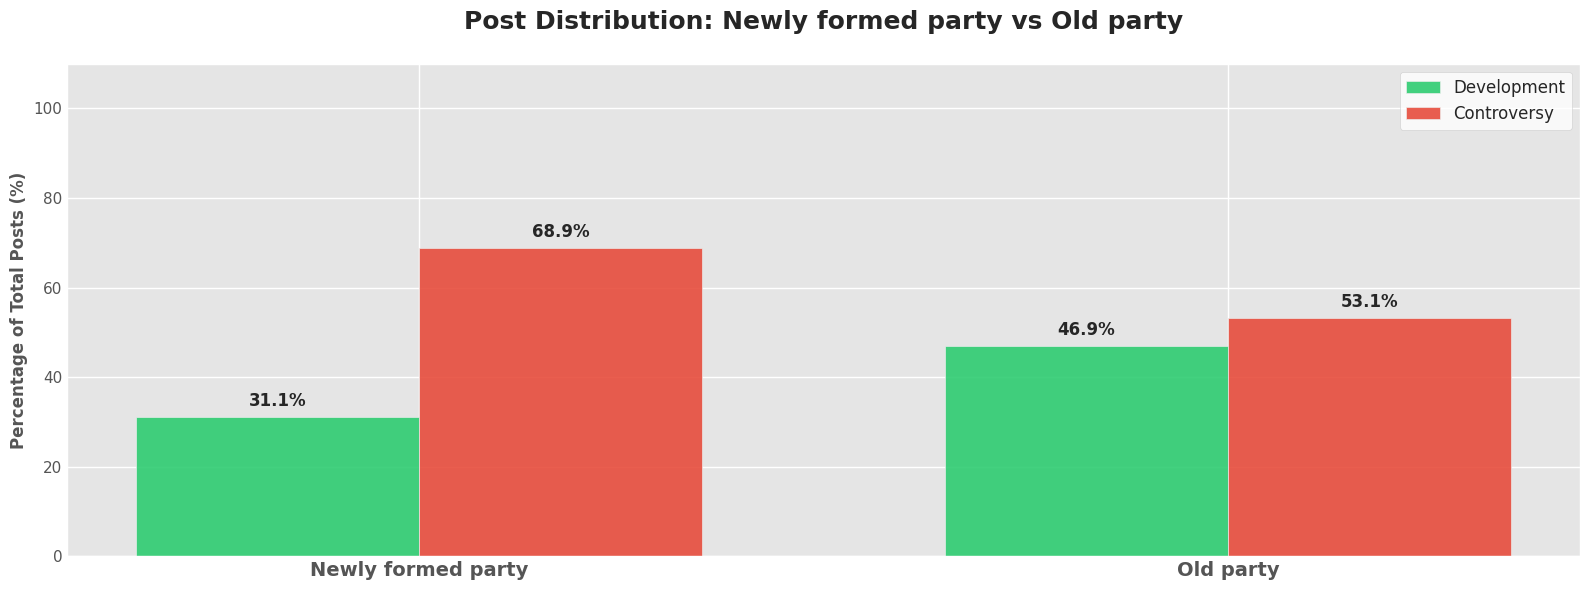

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Define the Groups (3 vs 3 Split)
# Old Parties: Nepali Congress, CPN (UML), CPN (Maoist Centre)
# Newly Formed Parties: Janamat Party, CPN (Unified Socialist), Rastriya Swatantra Party (RSP)

# 2. Data from your model training results
# As observed in the project analysis:
categories = ['Newly formed party', 'Old party']
development = [31.1, 46.9]
controversy = [68.9, 53.1]

# 3. Visualization Styling
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16, 6))

x = np.arange(len(categories))
width = 0.35

# Plotting the bars
rects1 = ax.bar(x - width/2, development, width, label='Development', color='#2ecc71', alpha=0.9)
rects2 = ax.bar(x + width/2, controversy, width, label='Controversy', color='#e74c3c', alpha=0.9)

# 4. Labels and Formatting
ax.set_ylabel('Percentage of Total Posts (%)', fontsize=12, fontweight='bold')
ax.set_title('Post Distribution: Newly formed party vs Old party', fontsize=18, fontweight='bold', pad=25)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=14, fontweight='bold')
ax.legend(fontsize=12, frameon=True, facecolor='white')
ax.set_ylim(0, 110)

# Function to add percentage labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('party_analysis_final.png', dpi=300)
plt.show()